<a href="https://colab.research.google.com/github/springboardmentor3847a-cloud/ImpactSense-Earthquake-Impact-Prediction/blob/Sankalp_Patil/ImpactSense_Earthquake_Impact_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                time   magnitude   longitude    latitude  \
count                            492  492.000000  492.000000  492.000000   
mean   2023-08-15 07:29:14.622050560    4.800772   24.556356   -0.017742   
min       2023-08-01 02:20:46.066000    4.500000 -179.931400  -62.177500   
25%    2023-08-07 00:07:31.091749888    4.500000  -75.063325  -21.994050   
50%    2023-08-15 00:00:27.827500032    4.700000   70.097650   -1.305250   
75%    2023-08-22 19:23:30.149750016    4.900000  129.117575   21.743200   
max       2023-08-31 21:43:25.888000    7.100000  179.899300   83.475200   
std                              NaN    0.375329  119.982102   29.960864   

            depth  
count  492.000000  
mean    73.788683  
min      2.963000  
25%     10.000000  
50%     25.064500  
75%     71.293500  
max    646.537000  
std    125.042290  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 6 columns):
 #   Column     Non-Null Count 

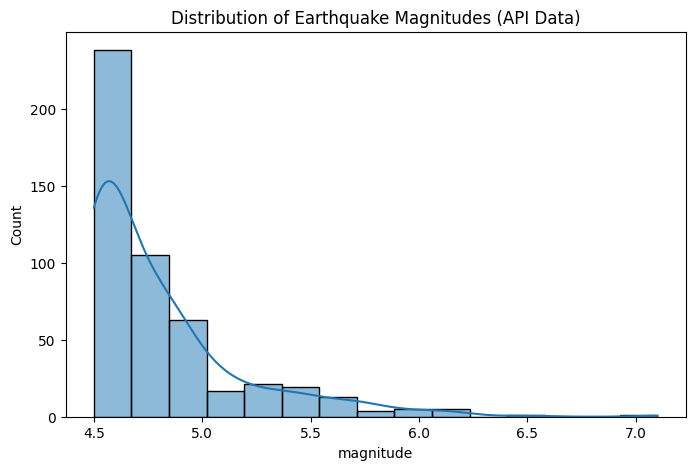

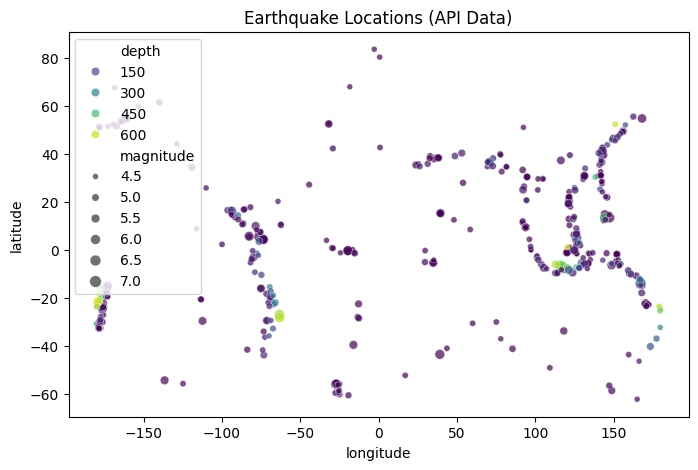

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch earthquake data from USGS API
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2023-08-01",
    "endtime": "2023-09-01",
    "minmagnitude": 4.5
}
response = requests.get(url, params=params).json()

records = []
for feat in response['features']:
    props = feat['properties']
    geom = feat['geometry']
    records.append({
        "time": pd.to_datetime(props['time'], unit='ms'),
        "place": props['place'],
        "magnitude": props['mag'],
        "longitude": geom['coordinates'][0],
        "latitude": geom['coordinates'][1],
        "depth": geom['coordinates'][2]
    })
df_api = pd.DataFrame(records)

# --- EDA ---
print(df_api.describe())
print(df_api.info())

# --- Visualizations ---
plt.figure(figsize=(8,5))
sns.histplot(df_api['magnitude'], bins=15, kde=True)
plt.title("Distribution of Earthquake Magnitudes (API Data)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_api, x="longitude", y="latitude", size="magnitude", hue="depth", alpha=0.7, palette="viridis")
plt.title("Earthquake Locations (API Data)")
plt.show()

Columns in the CSV file: ['Time', 'Place', 'Latitude', 'Longitude', 'Depth', 'Mag', 'MagType', 'nst', 'gap', 'dmin', 'rms', 'net', 'ID', 'Updated', 'Unnamed: 14', 'Type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource']
                                      Date      Latitude     Longitude  \
count                                37197  37197.000000  37197.000000   
mean   1980-06-09 10:32:45.414219840+00:00      5.322071     39.438045   
min       1904-04-04 10:02:34.560000+00:00    -77.080000   -179.997000   
25%       1961-09-27 12:07:31.150000+00:00    -16.599000    -75.283000   
50%       1985-06-11 11:12:28.720000+00:00      1.054000     98.923000   
75%       2004-09-03 19:04:47.980000+00:00     33.407000    143.408000   
max       2023-02-17 09:37:34.868000+00:00     87.199000    179.998100   
std                                    NaN     30.754945    122.872211   

              Depth     Magnitude  
count  37197.000000  37197.000

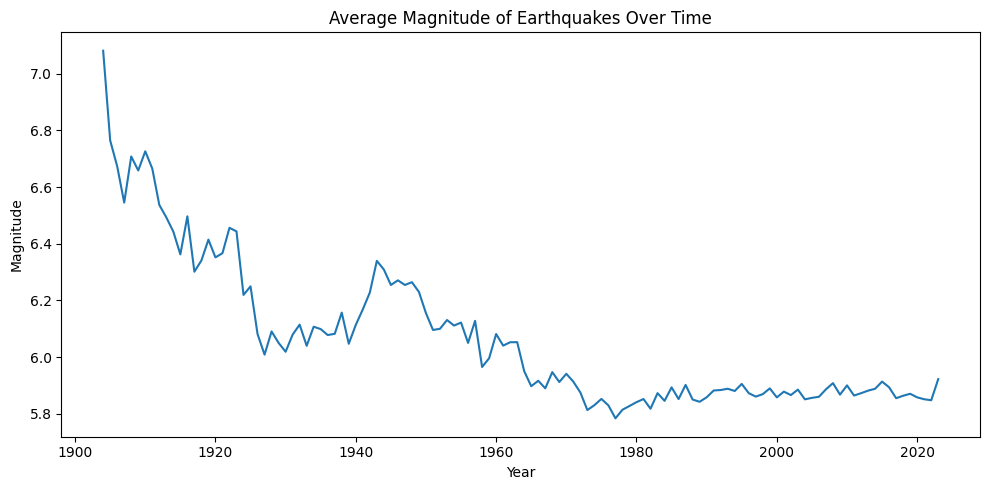

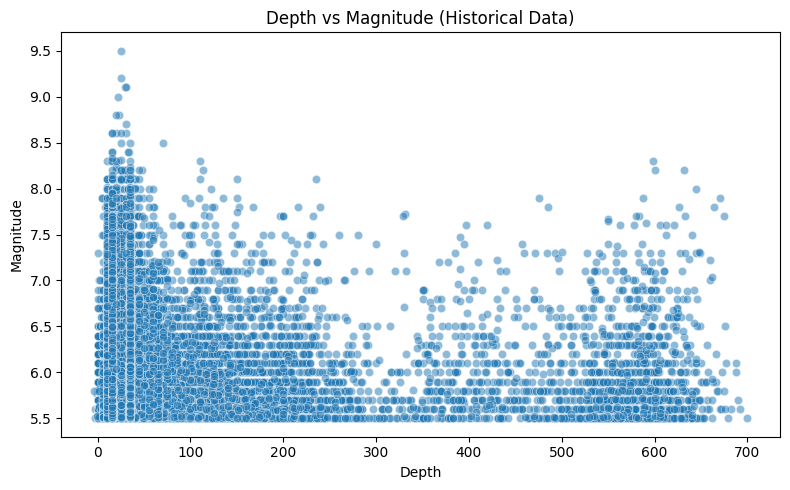

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = "/content/drive/MyDrive/datasets/Significant Earthquake Dataset 1900-2023.csv"

# Load CSV and inspect columns
df_hist = pd.read_csv(CSV_PATH)
print("Columns in the CSV file:", df_hist.columns.tolist())

# Map common variants to canonical names
canonical_targets = {
    'Date': ['date', 'time', 'timestamp', 'datetime'],
    'Latitude': ['latitude', 'lat'],
    'Longitude': ['longitude', 'lon', 'long'],
    'Depth': ['depth'],
    'Magnitude': ['magnitude', 'mag']
}

lower_to_original = {c.lower(): c for c in df_hist.columns}
rename_map = {}
missing = []
for canon, variants in canonical_targets.items():
    found = None
    for v in variants:
        if v in lower_to_original:
            found = lower_to_original[v]
            break
    if found is None:
        missing.append(canon)
    else:
        rename_map[found] = canon

if missing:
    raise KeyError(f"Required columns not found for {missing}. Available: {list(df_hist.columns)}")

# Rename detected columns to canonical names
df_hist = df_hist.rename(columns=rename_map)

# Keep only the needed columns
df_hist = df_hist[['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

# Parse and type-cast
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')
for col in ['Latitude', 'Longitude', 'Depth', 'Magnitude']:
    df_hist[col] = pd.to_numeric(df_hist[col], errors='coerce')

# Drop rows with missing essentials
df_hist = df_hist.dropna(subset=['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude']).reset_index(drop=True)

# --- EDA ---
print(df_hist.describe(include='all'))
print("Missing values:", df_hist.isnull().sum().to_dict())

# Time series trend
df_hist['Year'] = df_hist['Date'].dt.year
yearly = df_hist.groupby('Year', as_index=False)['Magnitude'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly, x='Year', y='Magnitude')
plt.title("Average Magnitude of Earthquakes Over Time")
plt.tight_layout()
plt.show()

# Magnitude vs Depth
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_hist, x='Depth', y='Magnitude', alpha=0.5)
plt.title("Depth vs Magnitude (Historical Data)")
plt.tight_layout()
plt.show()

Setting CRS to EPSG:4326 (WGS84)
Soil data loaded successfully!
Columns: ['SNUM', 'FAOSOIL', 'DOMSOI', 'PHASE1', 'PHASE2', 'MISCLU1', 'MISCLU2', 'PERMAFROST', 'CNTCODE', 'CNTNAME', 'SQKM', 'COUNTRY', 'geometry']
Number of soil types: 34112
CRS: EPSG:4326

First few rows:
   SNUM FAOSOIL DOMSOI PHASE1 PHASE2 MISCLU1 MISCLU2 PERMAFROST  CNTCODE  \
0  3479  Rx1-2c     Rx   None   None       0       0          1       85   
1  6998      GL     GL   None   None       0       0          1       85   
2  6998      GL     GL   None   None       0       0          1       85   
3  6998      GL     GL   None   None       0       0          1       85   
4  3479  Rx1-2c     Rx   None   None       0       0          1       85   

  CNTNAME    SQKM    COUNTRY  \
0      GL  4194.0  GREENLAND   
1      GL  8798.0  GREENLAND   
2      GL   659.0  GREENLAND   
3      GL    69.0  GREENLAND   
4      GL   204.0  GREENLAND   

                                            geometry  
0  POLYGON ((-34.67598 

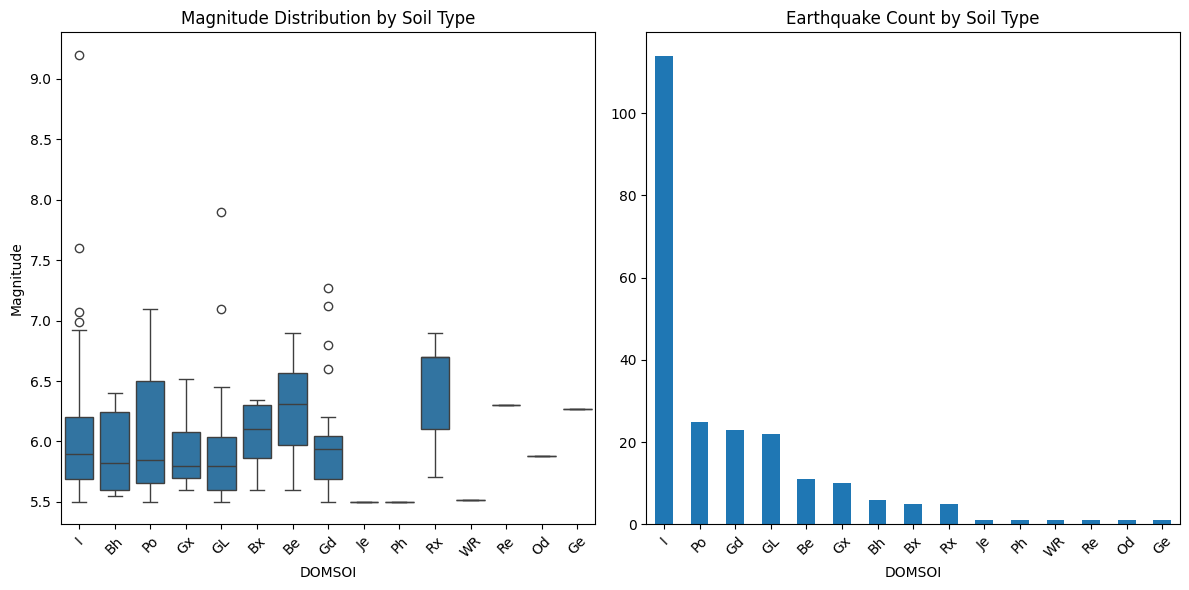

/tmp/ipython-input-3976559851.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


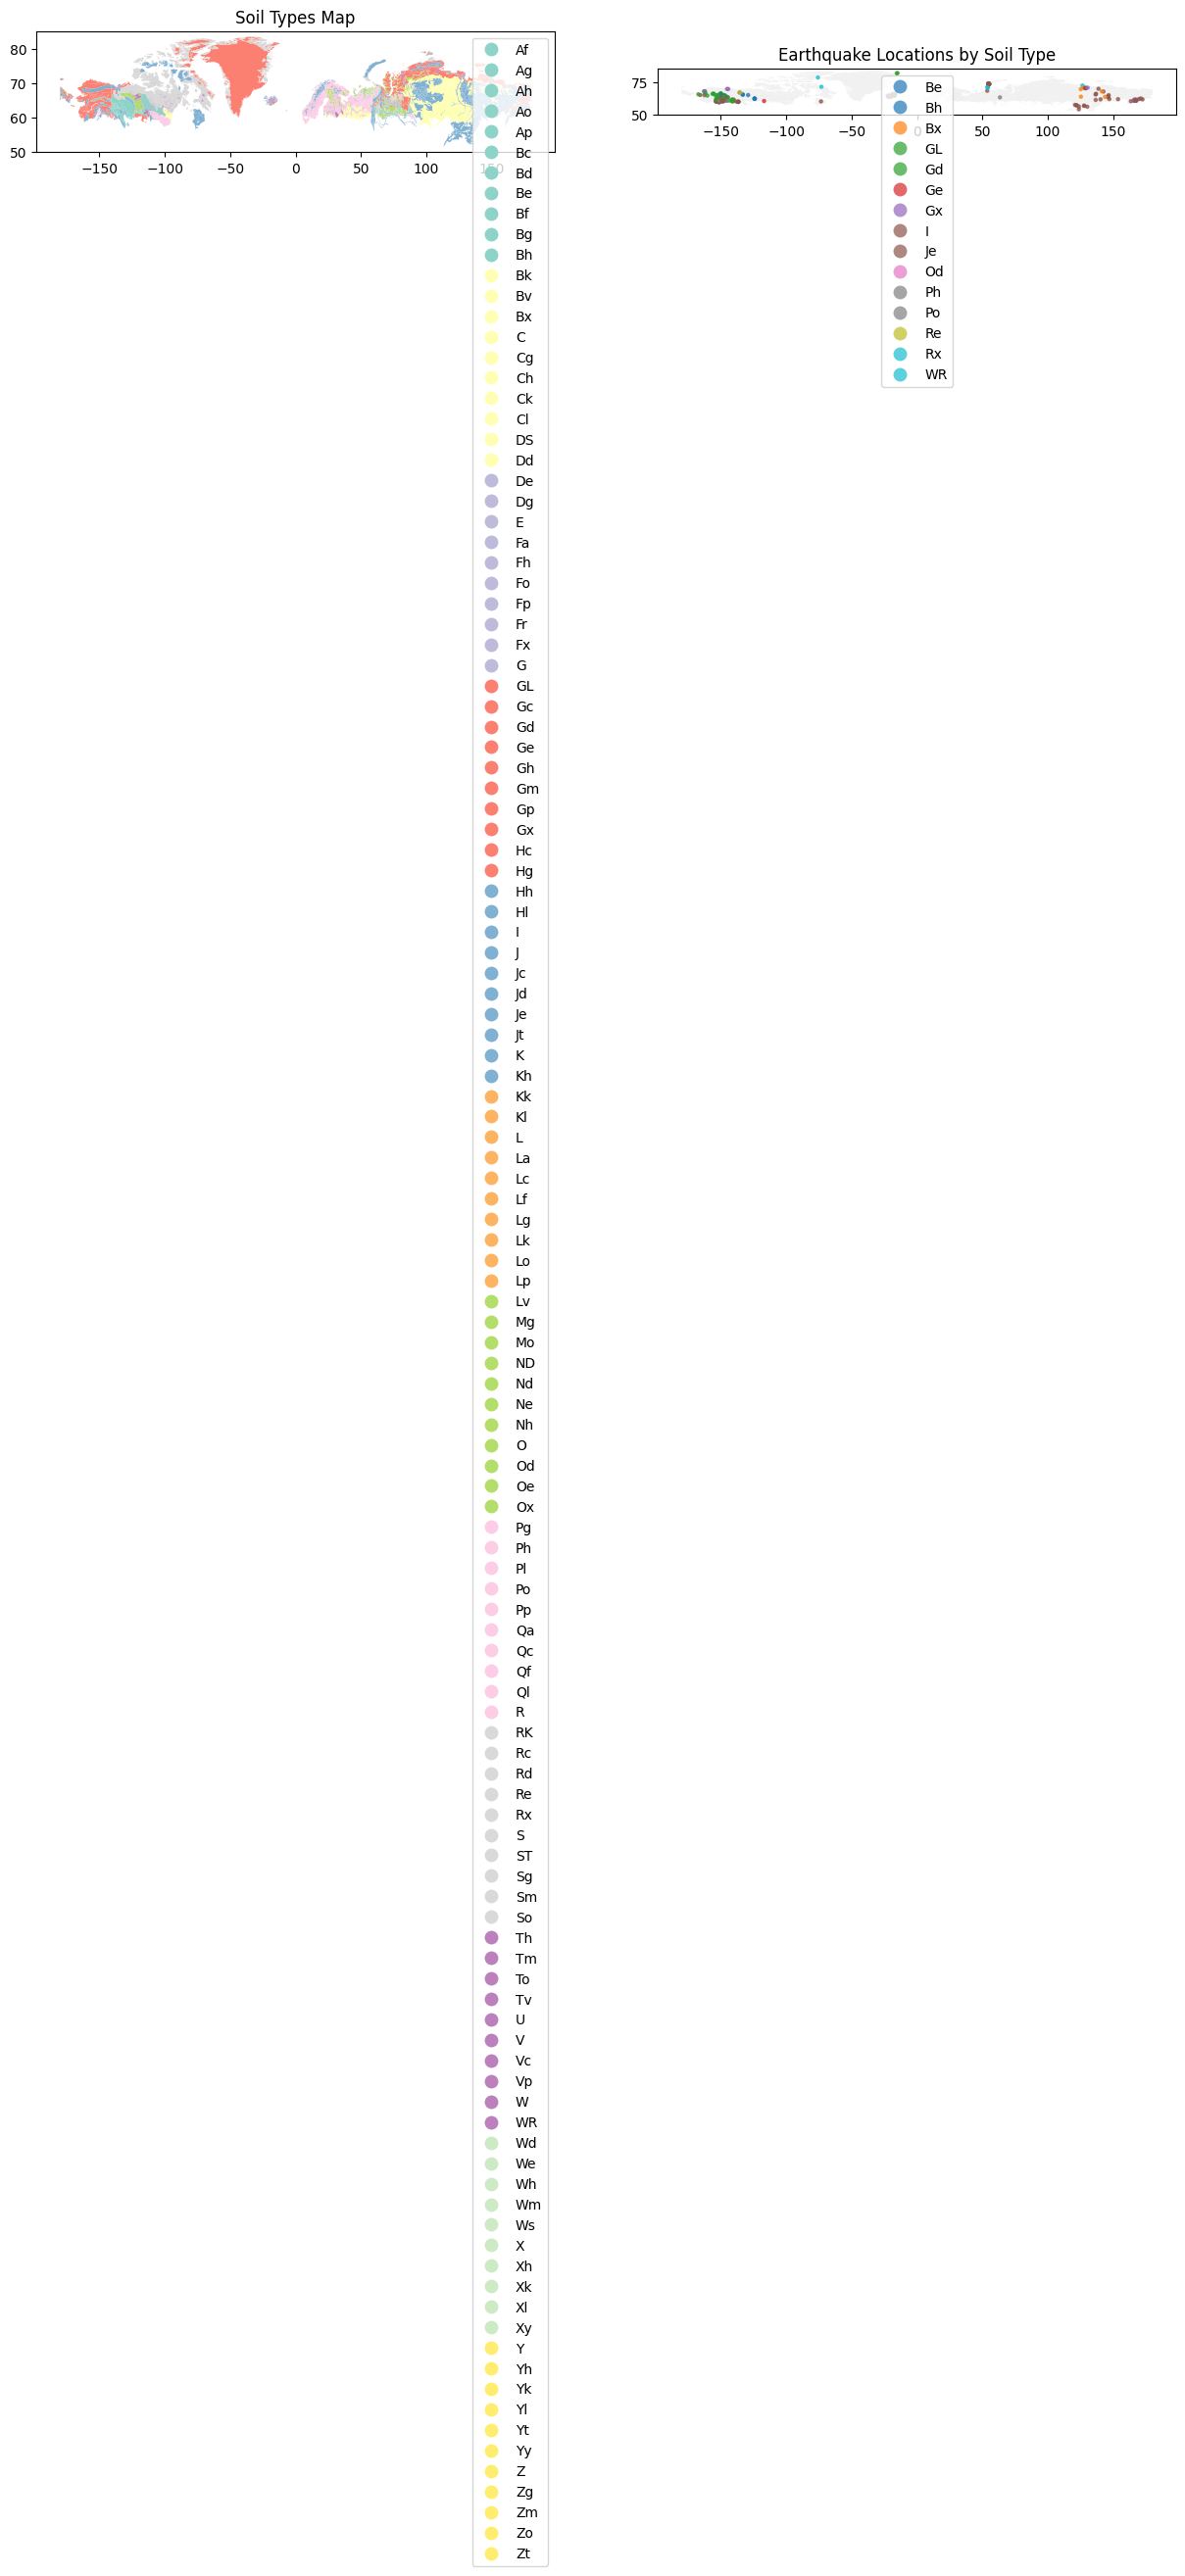


Statistical summary by soil type:
        count      mean       std   min   max
DOMSOI                                       
Be         11  6.257273  0.418786  5.60  6.90
Bh          6  5.916667  0.384326  5.55  6.40
Bx          5  6.040000  0.311127  5.60  6.34
GL         22  5.955909  0.585627  5.50  7.90
Gd         23  6.025217  0.484101  5.50  7.27
Ge          1  6.270000       NaN  6.27  6.27
Gx         10  5.932000  0.316958  5.60  6.52
I         114  6.028596  0.525271  5.50  9.20
Je          1  5.500000       NaN  5.50  5.50
Od          1  5.880000       NaN  5.88  5.88
Ph          1  5.500000       NaN  5.50  5.50
Po         25  6.052400  0.508612  5.50  7.10
Re          1  6.300000       NaN  6.30  6.30
Rx          5  6.422000  0.498417  5.71  6.90
WR          1  5.520000       NaN  5.52  5.52


In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Point

def load_soil_data(shapefile_path):
    """Load soil data with error handling"""
    try:
        # Load the shapefile
        soil_data = gpd.read_file(shapefile_path)


        if soil_data.crs is None:
            soil_data = soil_data.set_crs("EPSG:4326")
            print("Setting CRS to EPSG:4326 (WGS84)")

        return soil_data

    except Exception as e:
        print(f"Error loading shapefile: {e}")
        return None

# Load soil data
soil_data = load_soil_data("/content/drive/MyDrive/datasets/dsmw/DSMW/DSMW.shp")

if soil_data is not None:
    print("Soil data loaded successfully!")
    print(f"Columns: {soil_data.columns.tolist()}")
    print(f"Number of soil types: {len(soil_data)}")
    print(f"CRS: {soil_data.crs}")
    print("\nFirst few rows:")
    print(soil_data.head())

    # Check available columns for soil classification
    # Common column names in FAO DSMW:
    possible_soil_columns = ['SU_SYM90', 'DOMSOI', 'SU_SYM85', 'SOIL', 'CODE']
    available_soil_cols = [col for col in possible_soil_columns if col in soil_data.columns]
    print(f"\nAvailable soil columns: {available_soil_cols}")

    if available_soil_cols:
        soil_column = available_soil_cols[0]  # Using the first available soil column
        print(f"Using soil column: {soil_column}")

        # Convert earthquake data to GeoDataFrame
        eq_points = gpd.GeoDataFrame(
            df_hist,
            geometry=gpd.points_from_xy(df_hist.Longitude, df_hist.Latitude),
            crs="EPSG:4326"
        )

        # Ensure both datasets have the same CRS
        soil_data = soil_data.to_crs(eq_points.crs)

        print(f"Earthquake points: {len(eq_points)}")
        print(f"Soil polygons: {len(soil_data)}")

        # Spatial join - find which soil polygon contains each earthquake point
        eq_with_soil = gpd.sjoin(
            eq_points,
            soil_data[[soil_column, 'geometry']],
            how="left",
            predicate='within'
        )

        # Check results
        print(f"\nEarthquakes with soil data: {len(eq_with_soil)}")
        print(f"Earthquakes without soil data (NaN): {eq_with_soil[soil_column].isna().sum()}")

        # EDA Analysis
        print(f"\nSoil type distribution:")
        print(eq_with_soil[soil_column].value_counts())

        # Magnitude distribution by soil type
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.boxplot(data=eq_with_soil, x=soil_column, y="Magnitude")
        plt.title("Magnitude Distribution by Soil Type")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        soil_counts = eq_with_soil[soil_column].value_counts()
        soil_counts.plot(kind='bar')
        plt.title("Earthquake Count by Soil Type")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Map visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Soil map
        soil_data.plot(column=soil_column, ax=ax1, legend=True, cmap='Set3')
        ax1.set_title("Soil Types Map")

        # Plot 2: Earthquakes over soil types
        soil_data.plot(ax=ax2, color='lightgrey', alpha=0.3)
        eq_with_soil.plot(ax=ax2, column=soil_column, legend=True,
                         markersize=5, alpha=0.7)
        ax2.set_title("Earthquake Locations by Soil Type")

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("\nStatistical summary by soil type:")
        stats_by_soil = eq_with_soil.groupby(soil_column)['Magnitude'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(stats_by_soil)

    else:
        print("No standard soil classification columns found.")
        print("Available columns:", soil_data.columns.tolist())

else:
    print("Failed to load soil data.")

    # Debug: Check if files are accessible
    dataset_dir = "/content/drive/MyDrive/datasets/dsmw/DSMW"
    if os.path.exists(dataset_dir):
        files = os.listdir(dataset_dir)
        print(f"Files in directory: {files}")
    else:
        print(f"Directory does not exist: {dataset_dir}")


Missing values per column:
Date               0
Latitude           0
Longitude          0
Depth              0
Magnitude          0
Year               0
geometry           0
index_right    36970
DOMSOI         36970
dtype: int64


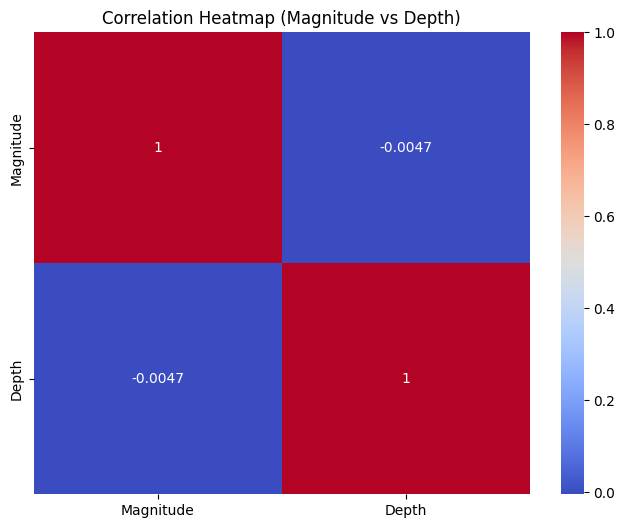

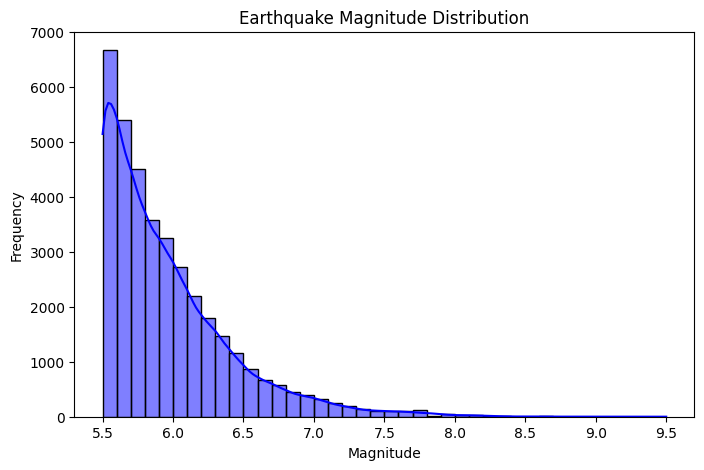

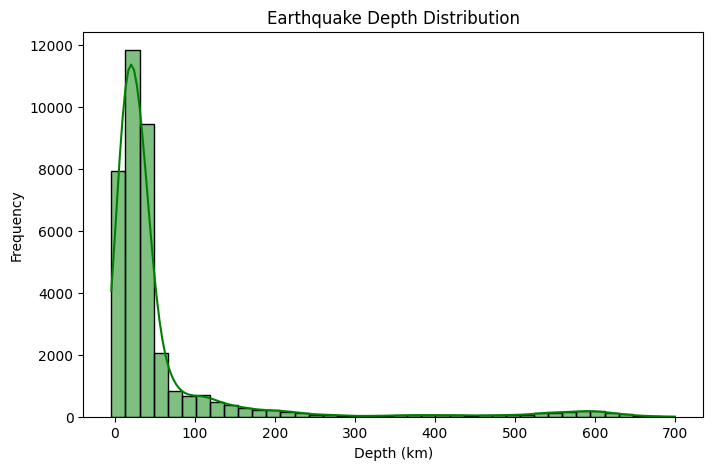

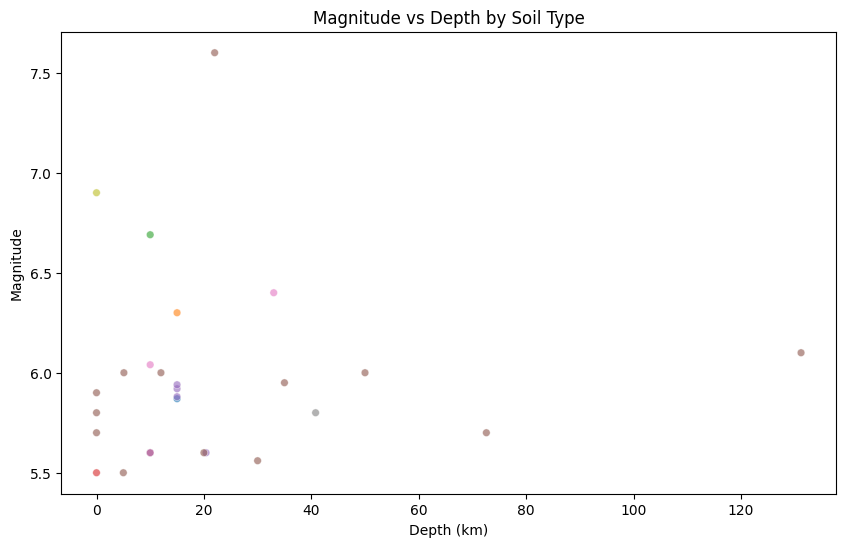

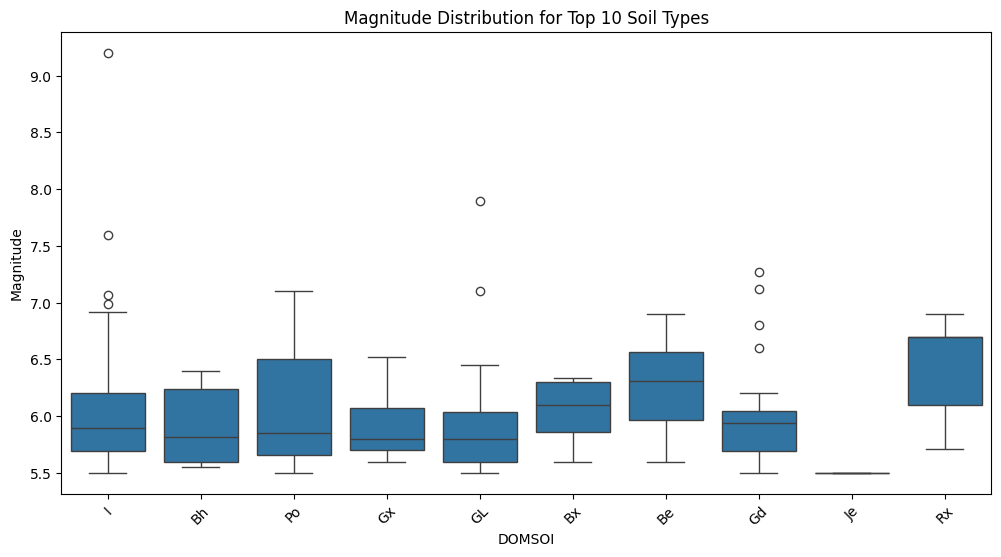

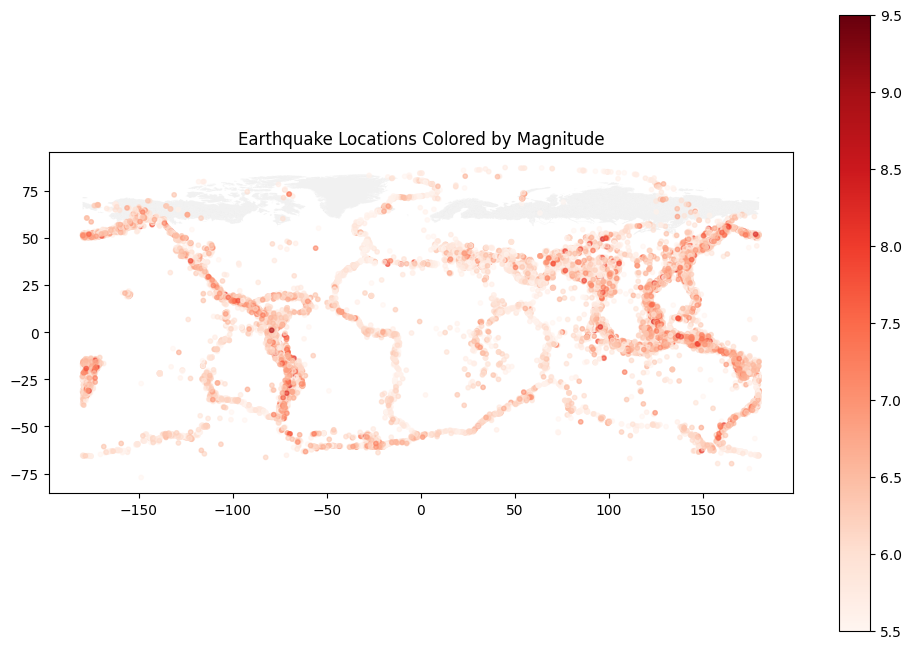

In [18]:
# --- Additional Exploratory Data Analysis ---

# 1. Missing values check
print("\nMissing values per column:")
print(eq_with_soil.isna().sum())

# 2. Correlation heatmap (numerical variables only)
plt.figure(figsize=(8,6))
sns.heatmap(eq_with_soil[['Magnitude','Depth']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Magnitude vs Depth)")
plt.show()

# 3. Magnitude histogram
plt.figure(figsize=(8,5))
sns.histplot(eq_with_soil['Magnitude'], bins=40, kde=True, color="blue")
plt.title("Earthquake Magnitude Distribution")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

# 4. Depth distribution
plt.figure(figsize=(8,5))
sns.histplot(eq_with_soil['Depth'], bins=40, kde=True, color="green")
plt.title("Earthquake Depth Distribution")
plt.xlabel("Depth (km)")
plt.ylabel("Frequency")
plt.show()

# 5. Magnitude vs Depth scatter (colored by soil type)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=eq_with_soil.sample(5000, random_state=42),  # sample for clarity
    x="Depth", y="Magnitude", hue="DOMSOI", alpha=0.6, s=30, legend=False
)
plt.title("Magnitude vs Depth by Soil Type")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()

# 6. Top N soil types vs Magnitude
top_soils = eq_with_soil['DOMSOI'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(
    data=eq_with_soil[eq_with_soil['DOMSOI'].isin(top_soils)],
    x="DOMSOI", y="Magnitude"
)
plt.title("Magnitude Distribution for Top 10 Soil Types")
plt.xticks(rotation=45)
plt.show()

# 7. Map: magnitude intensity
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
soil_data.plot(ax=ax, color="lightgrey", alpha=0.3)
eq_with_soil.plot(
    ax=ax,
    column="Magnitude",
    cmap="Reds",
    markersize=10,
    alpha=0.6,
    legend=True
)
ax.set_title("Earthquake Locations Colored by Magnitude")
plt.show()


API dataset columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Source']
Historical dataset columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Source']
Common columns available: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Source']

Date column types before conversion:
df_api Date type: datetime64[ns]
df_hist Date type: datetime64[ns]
Failed date conversions in df_api: 0
Failed date conversions in df_hist: 0
df_api Date type after conversion: datetime64[ns]
df_hist Date type after conversion: datetime64[ns]

Unified dataset shape: (37689, 6)
Data sources distribution:
Source
Historical    37197
API             492
Name: count, dtype: int64

First few rows:
                     Date  Latitude  Longitude   Depth  Magnitude      Source
0 2023-02-17 09:37:34.868   -6.5986   132.0763  38.615        6.1  Historical
1 2023-02-16 05:37:05.138  -15.0912   167.0294  36.029        5.6  Historical
2 2023-02-15 18:10:10.060   12.3238   123.8662  20.088      

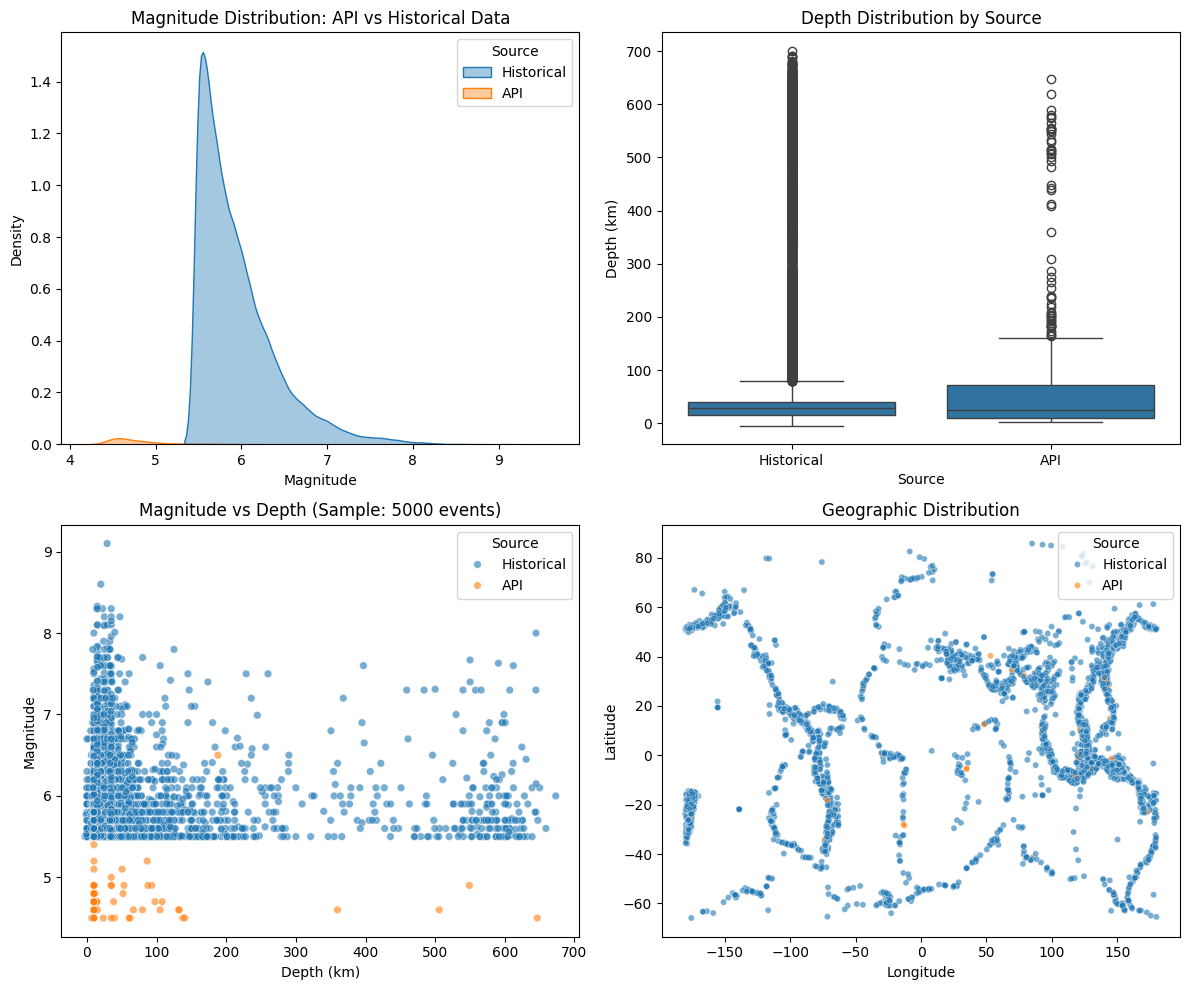

Date column type before Year extraction: datetime64[ns]


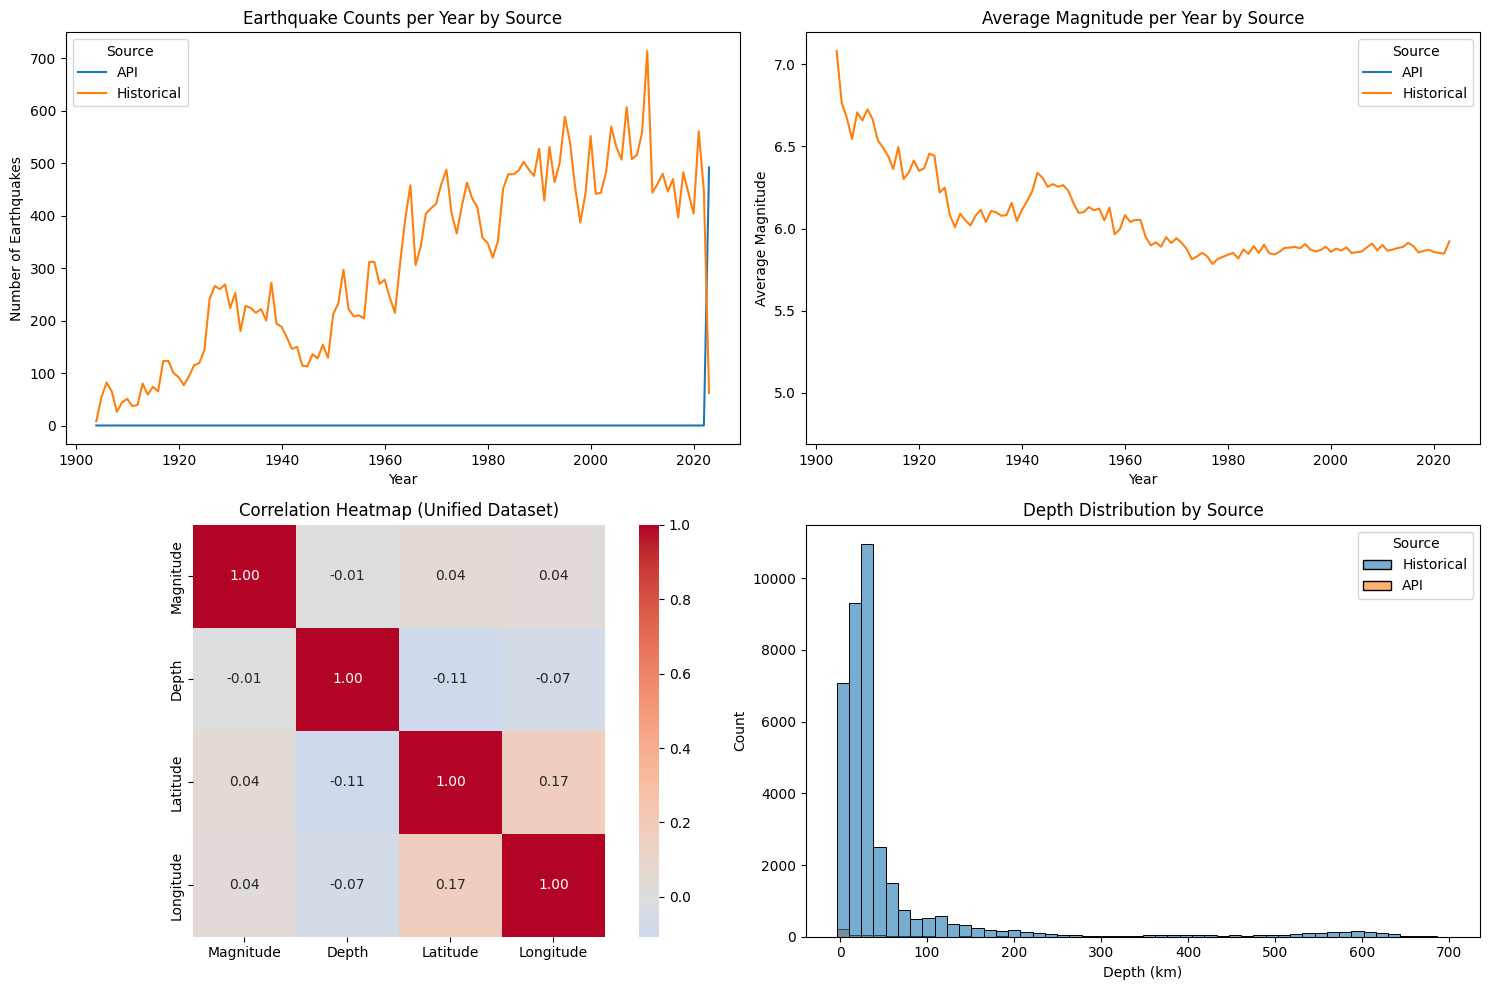

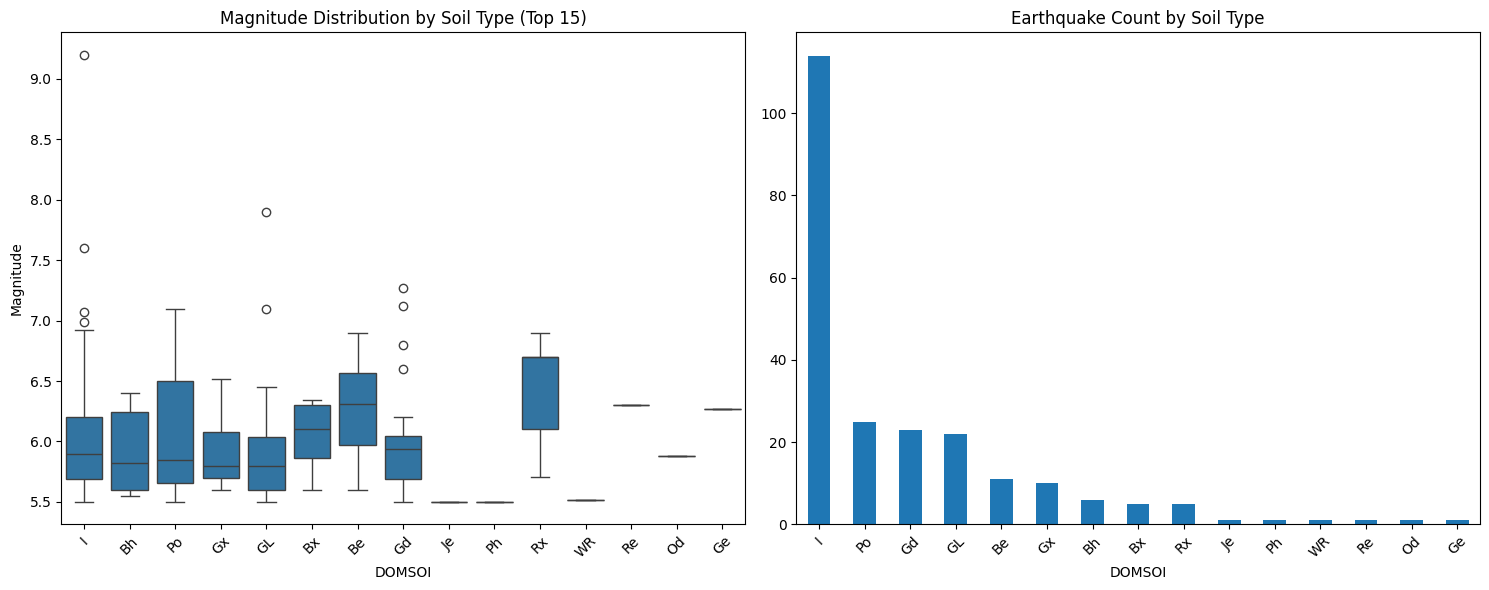


=== SOIL TYPE ANALYSIS ===
       Magnitude                 Depth        
           count   mean    std    mean     std
DOMSOI                                        
Be            11  6.257  0.419  11.973   4.916
Bh             6  5.917  0.384  14.667   9.201
Bx             5  6.040  0.311  10.600   6.841
GL            22  5.956  0.586  25.913  36.110
Gd            23  6.025  0.484  11.965   4.544
Ge             1  6.270    NaN  15.000     NaN
Gx            10  5.932  0.317  16.320   7.117
I            114  6.029  0.525  27.627  37.788
Je             1  5.500    NaN   0.000     NaN
Od             1  5.880    NaN  15.000     NaN


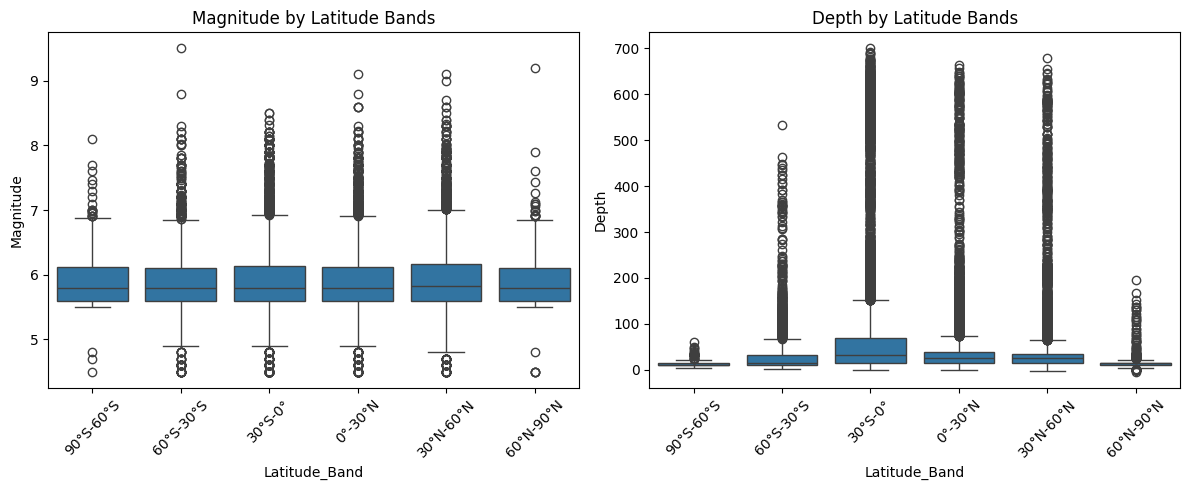


=== UNIFIED DATASET SUMMARY ===
Total earthquakes: 37,689
Time range: 1904-04-04 10:02:34.560000 to 2023-08-31 21:43:25.888000
Geographic range: Lat(-77.1 to 87.2)
                 Lon(-180.0 to 180.0)
Magnitude range: 4.5 to 9.5
Depth range: -4.0 to 700.0 km

=== DATA QUALITY CHECK ===
Missing values per column:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Source               0
merge_id             0
DOMSOI           37462
Year                 0
Latitude_Band        0
dtype: int64

Soil data coverage: 0.6%

Unified dataset saved to: unified_earthquake_data.csv


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1. Align API + Historical datasets ---
print("API dataset columns:", df_api.columns.tolist())
print("Historical dataset columns:", df_hist.columns.tolist())

# Fix the column naming issue
df_api = df_api.rename(columns={
    "time": "Date",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "depth": "Depth",
    "magnitude": "Magnitude",
    "place": "Location"
})

# Add source identifiers
df_api["Source"] = "API"
df_hist["Source"] = "Historical"

# Handle missing 'Location' column if it doesn't exist in df_api
if 'Location' not in df_api.columns:
    df_api['Location'] = "Unknown"

# Keep consistent columns (ensure they exist in both datasets)
available_common_cols = []
for col in ["Date", "Latitude", "Longitude", "Depth", "Magnitude", "Location", "Source"]:
    if col in df_api.columns and col in df_hist.columns:
        available_common_cols.append(col)

print("Common columns available:", available_common_cols)

df_api = df_api[available_common_cols]
df_hist = df_hist[available_common_cols]

# --- Step 2. Fix timezone compatibility issue ---
print("\nDate column types before conversion:")
print(f"df_api Date type: {df_api['Date'].dtype}")
print(f"df_hist Date type: {df_hist['Date'].dtype}")

# Convert both to timezone-naive datetime to avoid conflicts
df_api['Date'] = pd.to_datetime(df_api['Date'], errors='coerce')
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')

# If historical data has timezone info, remove it
if df_hist['Date'].dtype == 'datetime64[ns, UTC]':
    df_hist['Date'] = df_hist['Date'].dt.tz_localize(None)

# Check for any failed conversions
print(f"Failed date conversions in df_api: {df_api['Date'].isna().sum()}")
print(f"Failed date conversions in df_hist: {df_hist['Date'].isna().sum()}")

# Remove rows with invalid dates
df_api = df_api.dropna(subset=['Date'])
df_hist = df_hist.dropna(subset=['Date'])

print(f"df_api Date type after conversion: {df_api['Date'].dtype}")
print(f"df_hist Date type after conversion: {df_hist['Date'].dtype}")

# --- Step 3. Merge both datasets ---
df_all = pd.concat([df_hist, df_api], ignore_index=True)

print("\nUnified dataset shape:", df_all.shape)
print("Data sources distribution:")
print(df_all['Source'].value_counts())
print("\nFirst few rows:")
print(df_all.head())
print(f"Unified Date type: {df_all['Date'].dtype}")

# --- Step 4. Attach Soil/Geological Data ---
# Create a unique identifier for merging
df_all['merge_id'] = df_all['Latitude'].round(3).astype(str) + '_' + df_all['Longitude'].round(3).astype(str)

# Prepare soil data with same identifier
if 'eq_with_soil' in globals():
    eq_with_soil['merge_id'] = eq_with_soil['Latitude'].round(3).astype(str) + '_' + eq_with_soil['Longitude'].round(3).astype(str)

    # Merge soil data
    df_all_geo = pd.merge(
        df_all,
        eq_with_soil[['merge_id', 'DOMSOI']].drop_duplicates(),
        on='merge_id',
        how='left'
    )
else:
    print("Soil data not available, proceeding without it")
    df_all_geo = df_all.copy()
    df_all_geo['DOMSOI'] = np.nan

print("\nUnified dataset with soil shape:", df_all_geo.shape)
print("Soil data coverage:", df_all_geo['DOMSOI'].notna().sum(), "out of", len(df_all_geo))
print("\nSample of unified dataset:")
print(df_all_geo.sample(5))

# --- Step 5. Comprehensive Exploratory Data Analysis Across Sources ---

# 1. Basic statistics by source
print("\n=== BASIC STATISTICS BY SOURCE ===")
print(df_all_geo.groupby('Source').agg({
    'Magnitude': ['count', 'mean', 'std', 'min', 'max'],
    'Depth': ['mean', 'std', 'min', 'max'],
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std']
}).round(3))

# 2. Distribution plots
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.kdeplot(data=df_all_geo, x="Magnitude", hue="Source", fill=True, alpha=0.4)
plt.title("Magnitude Distribution: API vs Historical Data")
plt.xlabel("Magnitude")

plt.subplot(2, 2, 2)
sns.boxplot(data=df_all_geo, x="Source", y="Depth")
plt.title("Depth Distribution by Source")
plt.ylabel("Depth (km)")

plt.subplot(2, 2, 3)
sample_size = min(5000, len(df_all_geo))
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Depth", y="Magnitude", hue="Source", alpha=0.6, s=30)
plt.title(f"Magnitude vs Depth (Sample: {sample_size} events)")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Longitude", y="Latitude", hue="Source", alpha=0.6, s=20)
plt.title("Geographic Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

# 6. Time-based analysis (now that dates are properly formatted)
# Double-check date type before extracting year
print(f"Date column type before Year extraction: {df_all_geo['Date'].dtype}")

# If still not datetime, force conversion
if not pd.api.types.is_datetime64_any_dtype(df_all_geo['Date']):
    df_all_geo['Date'] = pd.to_datetime(df_all_geo['Date'], errors='coerce')
    # Remove any rows with invalid dates
    df_all_geo = df_all_geo.dropna(subset=['Date'])

df_all_geo['Year'] = df_all_geo['Date'].dt.year

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
yearly_counts = df_all_geo.groupby(['Year', 'Source']).size().unstack(fill_value=0)
yearly_counts.plot(kind='line', ax=plt.gca())
plt.title("Earthquake Counts per Year by Source")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.legend(title="Source")

plt.subplot(2, 2, 2)
yearly_magnitude = df_all_geo.groupby(['Year', 'Source'])['Magnitude'].mean().unstack()
yearly_magnitude.plot(kind='line', ax=plt.gca())
plt.title("Average Magnitude per Year by Source")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.legend(title="Source")

plt.subplot(2, 2, 3)
correlation_data = df_all_geo[['Magnitude', 'Depth', 'Latitude', 'Longitude']].corr()
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", center=0,
            square=True, fmt=".2f")
plt.title("Correlation Heatmap (Unified Dataset)")

plt.subplot(2, 2, 4)
sns.histplot(data=df_all_geo, x='Depth', hue='Source', bins=50, alpha=0.6)
plt.title("Depth Distribution by Source")
plt.xlabel("Depth (km)")

plt.tight_layout()
plt.show()

# 7. Soil type analysis (if available)
if df_all_geo['DOMSOI'].notna().sum() > 0:
    plt.figure(figsize=(15, 6))

    top_soils = df_all_geo['DOMSOI'].value_counts().head(15).index
    soil_data_subset = df_all_geo[df_all_geo['DOMSOI'].isin(top_soils)]

    plt.subplot(1, 2, 1)
    sns.boxplot(data=soil_data_subset, x="DOMSOI", y="Magnitude")
    plt.title("Magnitude Distribution by Soil Type (Top 15)")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    soil_counts = soil_data_subset['DOMSOI'].value_counts()
    soil_counts.plot(kind='bar')
    plt.title("Earthquake Count by Soil Type")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== SOIL TYPE ANALYSIS ===")
    soil_stats = df_all_geo.groupby('DOMSOI').agg({
        'Magnitude': ['count', 'mean', 'std'],
        'Depth': ['mean', 'std']
    }).round(3)
    print(soil_stats.head(10))

# 8. Advanced spatial analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_all_geo['Latitude_Band'] = pd.cut(df_all_geo['Latitude'],
                                    bins=np.arange(-90, 91, 30),
                                    labels=['90°S-60°S', '60°S-30°S', '30°S-0°',
                                           '0°-30°N', '30°N-60°N', '60°N-90°N'])
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Magnitude')
plt.title("Magnitude by Latitude Bands")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Depth')
plt.title("Depth by Latitude Bands")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 9. Summary statistics for the unified dataset
print("\n=== UNIFIED DATASET SUMMARY ===")
print(f"Total earthquakes: {len(df_all_geo):,}")
print(f"Time range: {df_all_geo['Date'].min()} to {df_all_geo['Date'].max()}")
print(f"Geographic range: Lat({df_all_geo['Latitude'].min():.1f} to {df_all_geo['Latitude'].max():.1f})")
print(f"                 Lon({df_all_geo['Longitude'].min():.1f} to {df_all_geo['Longitude'].max():.1f})")
print(f"Magnitude range: {df_all_geo['Magnitude'].min():.1f} to {df_all_geo['Magnitude'].max():.1f}")
print(f"Depth range: {df_all_geo['Depth'].min():.1f} to {df_all_geo['Depth'].max():.1f} km")

# 10. Data quality check
print("\n=== DATA QUALITY CHECK ===")
print("Missing values per column:")
print(df_all_geo.isnull().sum())
print(f"\nSoil data coverage: {df_all_geo['DOMSOI'].notna().mean():.1%}")

# Save the unified dataset for future use
df_all_geo.to_csv('/content/drive/MyDrive/datasets/unified_earthquake_data.csv', index=False)
print("\nUnified dataset saved to: unified_earthquake_data.csv")

In [ ]:
Milestone 1

In [22]:
#m
# Load unified dataset
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/unified_earthquake_data.csv")

print("Missing values per column before cleaning:")
print(df.isnull().sum())

# --- Strategy ---
# Numeric: fill with median
num_cols = ['Magnitude', 'Depth']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical: fill with mode
cat_cols = ['DOMSOI'] # Removed 'Location' as it's not in the DataFrame
for col in cat_cols:
    # Check if the column exists before trying to fill NaN
    if col in df.columns:
        # Calculate mode only on non-null values to avoid errors with all NaN
        mode_val = df[col].mode()
        if not mode_val.empty:
            df[col] = df[col].fillna(mode_val[0])
        else:
            print(f"Warning: Column '{col}' has no non-null values to calculate mode.")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


print("\nMissing values after imputation:")
print(df.isnull().sum())

# Save intermediate version
df.to_csv("/content/drive/MyDrive/datasets/earthquake_cleaned_day1.csv", index=False)

Missing values per column before cleaning:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Source               0
merge_id             0
DOMSOI           37462
Year                 0
Latitude_Band        0
dtype: int64

Missing values after imputation:
Date             0
Latitude         0
Longitude        0
Depth            0
Magnitude        0
Source           0
merge_id         0
DOMSOI           0
Year             0
Latitude_Band    0
dtype: int64


In [24]:
#t
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_cleaned_day1.csv")

# Select numeric features
numeric_features = ['Magnitude', 'Depth']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print(df_scaled[numeric_features].describe())

# Save scaled dataset
df_scaled.to_csv("/content/drive/MyDrive/datasets/earthquake_scaled_day2.csv", index=False)


          Magnitude         Depth
count  3.768900e+04  3.768900e+04
mean  -3.981709e-16 -1.206578e-16
std    1.000013e+00  1.000013e+00
min   -3.036748e+00 -5.718370e-01
25%   -7.066293e-01 -3.987789e-01
50%   -2.829714e-01 -2.766364e-01
75%    4.160641e-01 -1.574085e-01
max    7.554699e+00  5.840419e+00


In [34]:
#w
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_scaled_day2.csv")

# Encode Soil Type (DOMSOI)
if 'DOMSOI' in df.columns:
    encoder = LabelEncoder()
    df['SoilType_Encoded'] = encoder.fit_transform(df['DOMSOI'])
else:
    df['SoilType_Encoded'] = -1  # fallback if missing

# Encode Location (optional, may be too high-cardinality)
# Removed encoding for 'Location' as it's not in the DataFrame
# df['Location_Encoded'] = LabelEncoder().fit_transform(df['Location'])

print(df[['DOMSOI', 'SoilType_Encoded']].head())

# Save encoded dataset
df.to_csv("/content/drive/MyDrive/datasets/earthquake_encoded_day3.csv", index=False)

  DOMSOI  SoilType_Encoded
0      I                 7
1      I                 7
2      I                 7
3      I                 7
4      I                 7


In [33]:
# Display a sample of the DataFrame to see different soil types and their encoding
print(df[['DOMSOI', 'SoilType_Encoded']].sample(10))

        DOMSOI  SoilType_Encoded
2246   Unknown                14
14129  Unknown                14
31564  Unknown                14
17027  Unknown                14
17657  Unknown                14
32602  Unknown                14
25525  Unknown                14
25814  Unknown                14
27877  Unknown                14
21473  Unknown                14


In [35]:
#t
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_encoded_day3.csv")

# 1. Magnitude Category
df['Magnitude_Class'] = pd.cut(
    df['Magnitude'],
    bins=[0, 4, 6, 7, 10],
    labels=['Low', 'Moderate', 'Strong', 'Major']
)

# 2. Depth Category
df['Depth_Class'] = pd.cut(
    df['Depth'],
    bins=[-1, 70, 300, 700],
    labels=['Shallow', 'Intermediate', 'Deep']
)

# 3. Risk Score (simple weighted sum)
df['Risk_Score'] = (
    (df['Magnitude'] * 0.7) +
    (np.log1p(df['Depth']) * 0.3)
)

# 4. Spatial Clusters
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['Region_Cluster'] = kmeans.fit_predict(coords)

print(df[['Magnitude', 'Depth', 'Risk_Score', 'Region_Cluster']].head())

# Save engineered dataset
df.to_csv("/content/drive/MyDrive/datasets/earthquake_features_day4.csv", index=False)


   Magnitude     Depth  Risk_Score  Region_Cluster
0   0.352515 -0.183686    0.185874               1
1  -0.706629 -0.207240   -0.564311               1
2   0.352515 -0.352436    0.116400               1
3  -0.494800  0.141527   -0.306650               1
4  -0.706629 -0.444321   -0.670910               4


In [36]:
#f
# Load latest version
df_final = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_features_day4.csv")

print("Final dataset shape:", df_final.shape)
print("Final columns:", df_final.columns.tolist())

# Save final dataset for modeling
df_final.to_csv("/content/drive/MyDrive/datasets/earthquake_preprocessed_week2.csv", index=False)


Final dataset shape: (37689, 15)
Final columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Source', 'merge_id', 'DOMSOI', 'Year', 'Latitude_Band', 'SoilType_Encoded', 'Magnitude_Class', 'Depth_Class', 'Risk_Score', 'Region_Cluster']


In [ ]:
MILESTONE 2 (BASELINE MODEL TRAINING)

In [37]:
#m
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_preprocessed_week2.csv")

# Example: Add target labels (Magnitude_Class from Week 2)
print("Sample Magnitude Classes:")
print(df[['Magnitude', 'Magnitude_Class']].head())

# Regression target = Magnitude (numeric)
# Classification target = Magnitude_Class (categorical)


Sample Magnitude Classes:
   Magnitude Magnitude_Class
0   0.352515             Low
1  -0.706629             NaN
2   0.352515             Low
3  -0.494800             NaN
4  -0.706629             NaN


In [38]:
#t
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features & target
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Check & drop rows with missing target (y)
df = df.dropna(subset=['Magnitude_Class'])
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Define preprocessing: numeric → median, categorical → most frequent
numeric_cols = ['Magnitude', 'Depth']
categorical_cols = ['SoilType_Encoded', 'Region_Cluster']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols)
    ])

# Build pipeline (imputation + logistic regression)
clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=500, multi_class='multinomial'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit + predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred))




/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression Report ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
       Major       0.00      0.00      0.00         0
    Moderate       1.00      0.81      0.89        31

    accuracy                           1.00      2906
   macro avg       0.67      0.60      0.63      2906
weighted avg       1.00      1.00      1.00      2906



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Decision Tree Report ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      0.97      0.98        31
      Strong       0.00      0.00      0.00         0

    accuracy                           1.00      2906
   macro avg       0.67      0.66      0.66      2906
weighted avg       1.00      1.00      1.00      2906



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


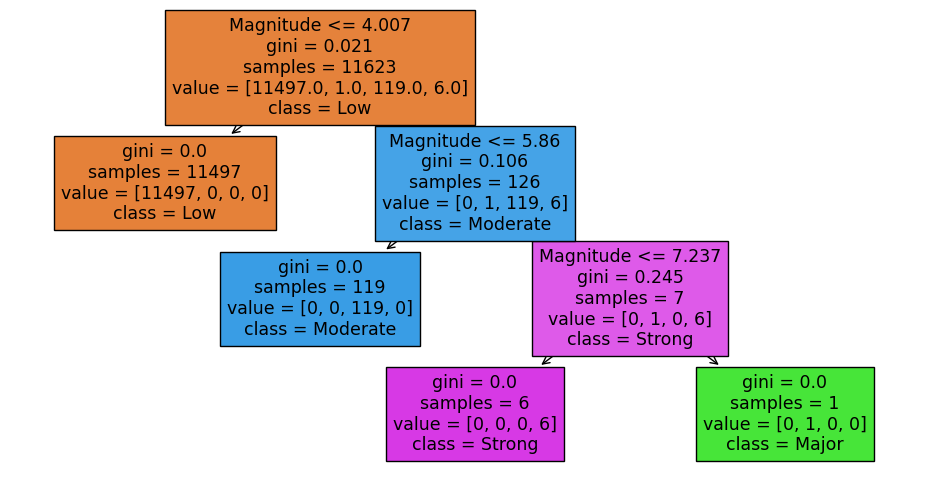

In [39]:
#w
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
print("\n=== Decision Tree Report ===")
print(classification_report(y_test, y_pred_tree))

# Visualize tree
plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True)
plt.show()


Logistic Regression Accuracy: 0.998
Decision Tree Accuracy: 1.000


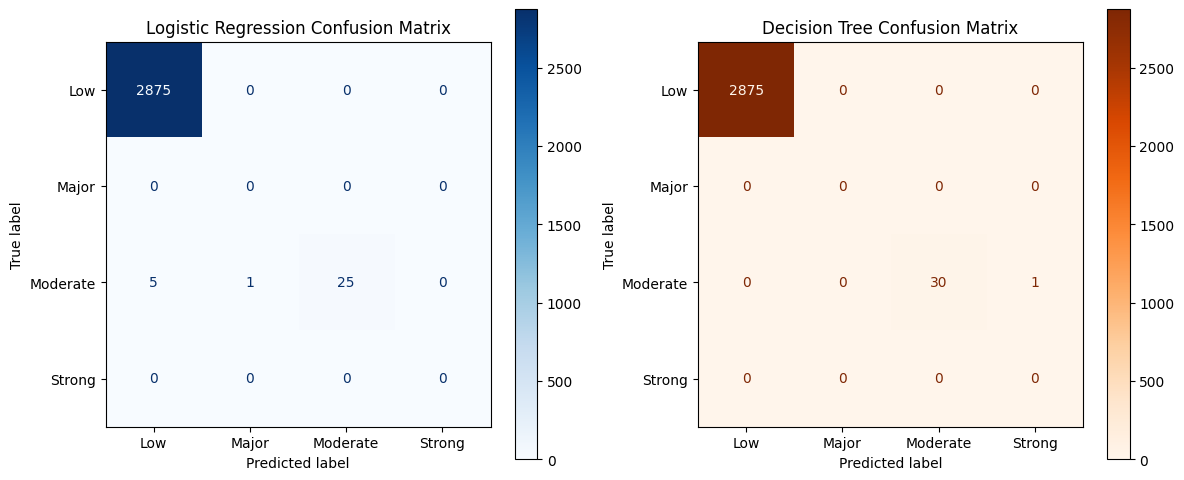

In [40]:
#t
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Logistic Regression
acc_log = accuracy_score(y_test, y_pred)
cm_log = confusion_matrix(y_test, y_pred, labels=clf.named_steps['model'].classes_)

# Decision Tree
acc_tree = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=tree.classes_)

print(f"Logistic Regression Accuracy: {acc_log:.3f}")
print(f"Decision Tree Accuracy: {acc_tree:.3f}")

# Confusion Matrix Plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_log, display_labels=clf.named_steps['model'].classes_).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression Confusion Matrix")

ConfusionMatrixDisplay(cm_tree, display_labels=tree.classes_).plot(ax=axes[1], cmap="Oranges")
axes[1].set_title("Decision Tree Confusion Matrix")

plt.tight_layout()
plt.show()



In [41]:
#f
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [acc_log, acc_tree]
})

print("\n=== Baseline Model Comparison ===")
print(results)

# Save baseline model results
results.to_csv("/content/drive/MyDrive/datasets/baseline_result_week3.csv", index=False)



=== Baseline Model Comparison ===
                 Model  Accuracy
0  Logistic Regression  0.997935
1        Decision Tree  0.999656


In [ ]:
Other model like RF AND XGBOOST


 Random Forest Accuracy: 1.000

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906



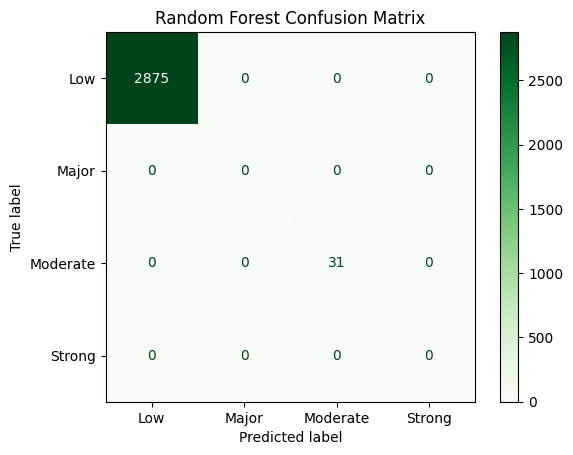


 Random Forest model saved as: random_forest_day1.pkl


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_features_day4.csv")

# Drop missing target rows if any
df = df.dropna(subset=['Magnitude_Class'])

# Features & Target
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Train-Test Split (same as Week 3) - Removed stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n Random Forest Accuracy: {acc_rf:.3f}")
print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm_rf, display_labels=rf.classes_)
disp.plot(cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Save Day 1 model performance
import joblib
joblib.dump(rf, "/content/drive/MyDrive/datasets/RF_day1.pkl")

print("\n Random Forest model saved as: random_forest_day1.pkl")

Class Weights: {'Low': np.float64(0.2527398451770027), 'Major': np.float64(2905.75), 'Moderate': np.float64(24.418067226890756), 'Strong': np.float64(484.2916666666667)}

Updated Random Forest Accuracy: 1.000

Updated Classification Report (Random Forest) 
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906



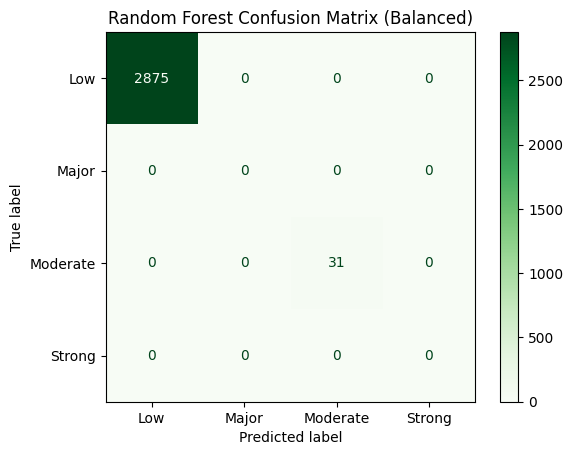


Balanced Random Forest saved as: random_forest_day1_balanced.pkl


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load data
df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_features_day4.csv")
df = df.dropna(subset=['Magnitude_Class'])

X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    # Removed stratify=y due to classes with single members
)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class Weights:", class_weight_dict)

# Train Random Forest with balanced classes
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    class_weight=class_weight_dict
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nUpdated Random Forest Accuracy: {acc_rf:.3f}")
print("\nUpdated Classification Report (Random Forest) ")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm_rf, display_labels=rf.classes_)
disp.plot(cmap="Greens")
plt.title("Random Forest Confusion Matrix (Balanced)")
plt.show()

# Save updated model
import joblib
joblib.dump(rf, "/content/drive/MyDrive/datasets/RF_day1.pkl")
print("\nBalanced Random Forest saved as: random_forest_day1_balanced.pkl")


Class Weights for XGBoost: {0: 0.2527398451770027, 2: 24.418067226890756, 3: 484.2916666666667, 1: 2905.75}

 XGBoost Accuracy: 1.000

 Classification Report (XGBoost) 
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906



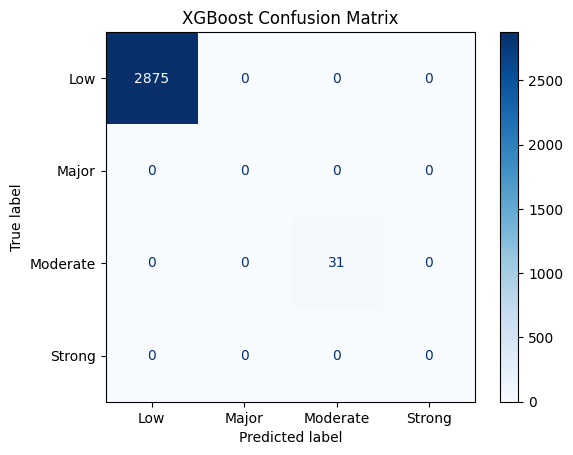


XGBoost model (dumped) saved as: XG_day2_dumped.raw.txt
Label encoder saved as: label_encoder.pkl


In [60]:
#t
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Load data
df = pd.read_csv("/content/drive/MyDrive/datasets/earthquake_features_day4.csv")
df = df.dropna(subset=['Magnitude_Class'])

# Encode target labels
le = LabelEncoder()
df['Magnitude_Class_Encoded'] = le.fit_transform(df['Magnitude_Class'])

# Features and target
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class_Encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Compute class weights
class_counts = pd.Series(y_train).value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}
print("\nClass Weights for XGBoost:", class_weights)

# Map sample weights
sample_weights = pd.Series(y_train).map(class_weights)

# Train model
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',
    num_class=len(le.classes_)
)

xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Predict (encoded)
y_pred_xgb = xgb.predict(X_test)

# Decode predictions and true labels
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred_xgb)

# Metrics
acc_xgb = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"\n XGBoost Accuracy: {acc_xgb:.3f}")
print("\n Classification Report (XGBoost) ")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save model + encoder using dump_model
xgb.get_booster().dump_model("/content/drive/MyDrive/datasets/XG_day2_dumped.raw.txt", with_stats=True)
joblib.dump(le, "/content/drive/MyDrive/datasets/lable_encoder.pkl")
print("\nXGBoost model (dumped) saved as: XG_day2_dumped.raw.txt")
print("Label encoder saved as: label_encoder.pkl")

In [48]:
#w
# Day 3 – Cross-Validation for Random Forest & XGBoost

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n Running Cross-Validation for Random Forest...")

# Random Forest WITHOUT class_weight during CV to avoid failure
rf_cv_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
)

rf_cv_scores = cross_val_score(rf_cv_model, X_train, y_train, cv=skf, scoring='accuracy')
print("Fold Accuracies:", rf_cv_scores)
print("Mean Accuracy:", rf_cv_scores.mean())

print("\nRunning Cross-Validation for XGBoost...")

xgb_cv_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_cv_scores = cross_val_score(xgb_cv_model, X_train, y_train, cv=skf, scoring='accuracy')
print("Fold Accuracies:", xgb_cv_scores)
print("Mean Accuracy:", xgb_cv_scores.mean())



 Running Cross-Validation for Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold Accuracies: [1.         0.99956989 0.99956989 1.         1.        ]
Mean Accuracy: 0.9998279569892473

Running Cross-Validation for XGBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold Accuracies: [ 1.  1. nan  1.  1.]
Mean Accuracy: nan


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1758, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expect

In [49]:
#t
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Assuming you already have:
# X_train, X_test, y_train, y_test
# Label-encoded y values: 0, 1, 2, 3

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. RANDOM FOREST TUNING
rf_model = RandomForestClassifier(random_state=42)

rf_param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=skf,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Tuning Random Forest...")
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("\nBest Random Forest Params:", rf_search.best_params_)

# Evaluate
rf_preds = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print("\nRandom Forest Accuracy (Tuned):", round(rf_acc, 3))
print("\nClassification Report (Random Forest) ")
print(classification_report(y_test, rf_preds))

# Save model
with open("random_forest_tuned.pkl", "wb") as f:
    pickle.dump(best_rf, f)
print("Tuned Random Forest saved as: random_forest_tuned.pkl")


# 2. XGBOOST TUNING
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)

xgb_param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=skf,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTuning XGBoost...")
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print("\nBest XGBoost Params:", xgb_search.best_params_)

# Evaluate
xgb_preds = best_xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
print("\nXGBoost Accuracy (Tuned):", round(xgb_acc, 3))
print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_test, xgb_preds))

# Save model
with open("xgboost_tuned.pkl", "wb") as f:
    pickle.dump(best_xgb, f)
print("Tuned XGBoost saved as: xgboost_tuned.pkl")


Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Best Random Forest Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}

Random Forest Accuracy (Tuned): 1.0

Classification Report (Random Forest) 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2875
           2       1.00      0.97      0.98        31
           3       0.00      0.00      0.00         0

    accuracy                           1.00      2906
   macro avg       0.67      0.66      0.66      2906
weighted avg       1.00      1.00      1.00      2906

Tuned Random Forest saved as: random_forest_tuned.pkl

Tuning XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py


Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}

XGBoost Accuracy (Tuned): 1.0

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2875
           2       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906

Tuned XGBoost saved as: xgboost_tuned.pkl


In [50]:

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# Use the same label-encoded y_train
print("Unique Encoded Classes:", np.unique(y_train))

# Step 1: Define correct class weights (based on encoded labels)
class_weights = {
    0: 0.25402724169829977,   # Low
    1: 995.4375,              # Major
    2: 16.385802469135804,    # Moderate
    3: 723.9545454545455      # Strong
}

# Step 2: Map weights to each training sample
sample_weights = np.array([class_weights[label] for label in y_train])

# Step 3: Initialize base model for GridSearch (no silent params)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    tree_method='hist',
    eval_metric='mlogloss'
)

#Step 4: Define improved grid with fewer params to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.05],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0, 1]
}

#Step 5: Run GridSearchCV with sample weights applied
print("\nTuning XGBoost with Class Weights...")
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train, sample_weight=sample_weights)

best_xgb = grid_search_xgb.best_estimator_
print("\nBest XGBoost Params:", grid_search_xgb.best_params_)

# Step 6: Evaluate tuned model
y_pred_xgb = best_xgb.predict(X_test)
print("\nXGBoost Accuracy (Tuned):", accuracy_score(y_test, y_pred_xgb))

print("\Classification Report (XGBoost)")
print(classification_report(y_test, y_pred_xgb))

# Step 7: Save model
joblib.dump(best_xgb, 'xgboost_tuned_weighted.pkl')
print("\nTuned XGBoost saved as: xgboost_tuned_weighted.pkl")


<>:59: SyntaxWarning: invalid escape sequence '\C'
<>:59: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-214394935.py:59: SyntaxWarning: invalid escape sequence '\C'
  print("\Classification Report (XGBoost)")
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Unique Encoded Classes: [0 1 2 3]

Tuning XGBoost with Class Weights...

Best XGBoost Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}

XGBoost Accuracy (Tuned): 1.0
\Classification Report (XGBoost)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2875
           2       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


Tuned XGBoost saved as: xgboost_tuned_weighted.pkl


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
16 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1758, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Exp

In [53]:
#f
import pandas as pd
import pickle
import joblib # Import joblib
from sklearn.metrics import accuracy_score, classification_report
import numpy as np # Import numpy

#  Load Tuned Models & Encoder
rf_model = pickle.load(open("/content/random_forest_tuned.pkl", "rb"))
xgb_model = joblib.load("/content/xgboost_tuned_weighted.pkl") # Load using joblib with correct path
label_encoder = joblib.load("/content/drive/MyDrive/datasets/lable_encoder.pkl") # Load using joblib with correct path

# Predictions
y_pred_rf = rf_model.predict(X_test) # Changed from y_test to X_test
y_pred_xgb = xgb_model.predict(X_test) # Changed from y_test to X_test

# Accuracy Scores
rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print("\n Model Accuracies:")
print(f"Random Forest: {rf_accuracy:.4f}")
print(f"XGBoost: {xgb_accuracy:.4f}")

# Get unique labels in y_test and their corresponding names
unique_labels_y_test = np.unique(y_test)
target_names_y_test = label_encoder.inverse_transform(unique_labels_y_test)


# Classification Reports
print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf, labels=unique_labels_y_test, target_names=target_names_y_test))
print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb, labels=unique_labels_y_test, target_names=target_names_y_test))

#  Summary Table
summary = pd.DataFrame({
    "Model": ["Random Forest (Tuned)", "XGBoost (Weighted + Tuned)"],
    "Accuracy": [rf_accuracy, xgb_accuracy],
})
print("\n Model Comparison Summary:")
print(summary)

#  Save Summary to CSV
summary.to_csv("model_comparison_summary.csv", index=False)
print("\n Summary saved as: model_comparison_summary.csv")

# Save both models again (optional)
pickle.dump(rf_model, open("best_random_forest.pkl", "wb"))
pickle.dump(xgb_model, open("best_xgboost.pkl", "wb"))
print(" Both models backed up as best_random_forest.pkl and best_xgboost.pkl")


 Model Accuracies:
Random Forest: 0.9997
XGBoost: 1.0000

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      0.97      0.98        31

   micro avg       1.00      1.00      1.00      2906
   macro avg       1.00      0.98      0.99      2906
weighted avg       1.00      1.00      1.00      2906


=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


 Model Comparison Summary:
                        Model  Accuracy
0       Random Forest (Tuned)  0.999656
1  XGBoost (Weighted + Tuned)  1.000000

 Summary saved as: model_comparison_summary.csv
 Bo

In [ ]:
#EVALUATION_REPORT

In [54]:
#m
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import joblib

# Load models
rf_model = pickle.load(open("best_random_forest.pkl", "rb"))
xgb_model = pickle.load(open("best_xgboost.pkl", "rb"))

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

print("\n Evaluation Metrics (Day 1)")

def print_metrics(name, y_true, y_pred):
    print(f"\n {name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")

print_metrics("Random Forest", y_test, y_pred_rf)
print_metrics("XGBoost", y_test, y_pred_xgb)



 Evaluation Metrics (Day 1)

 Random Forest
Accuracy: 0.9997
Precision (macro): 0.6667
Recall (macro): 0.6559
F1-score (macro): 0.6612

 XGBoost
Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1-score (macro): 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Reports (Day 2)

Random Forest
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      0.97      0.98        31

   micro avg       1.00      1.00      1.00      2906
   macro avg       1.00      0.98      0.99      2906
weighted avg       1.00      1.00      1.00      2906



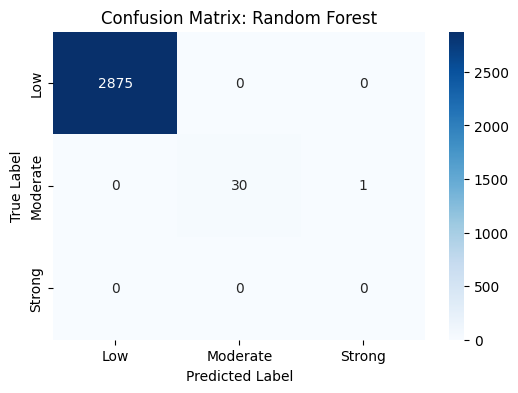

XGBoost
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2875
    Moderate       1.00      1.00      1.00        31

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906



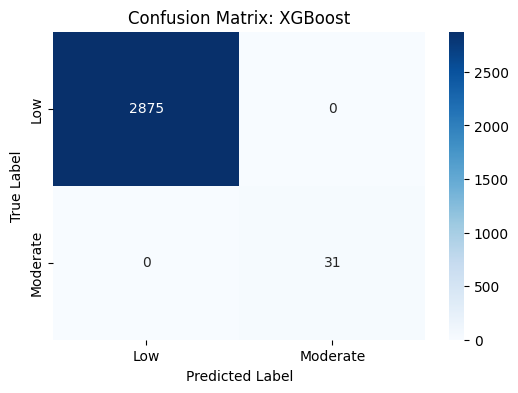

In [56]:
#t
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np # Import numpy

label_encoder = joblib.load("/content/drive/MyDrive/datasets/lable_encoder.pkl")
# Get all possible class names from the encoder
all_class_names = label_encoder.classes_

# Confusion Matrix Function
def plot_conf_matrix(y_true, y_pred, title, class_names):
    # Get unique labels present in y_true and y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    # Get the corresponding names for the unique labels
    display_class_names = label_encoder.inverse_transform(unique_labels)

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=display_class_names, yticklabels=display_class_names)
    plt.title(f"Confusion Matrix: {title}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

print("\nClassification Reports (Day 2)")
print("\nRandom Forest")
# Get unique labels in y_test
unique_y_test_labels = np.unique(y_test)
# Get the corresponding target names
target_names_for_report = label_encoder.inverse_transform(unique_y_test_labels)
print(classification_report(y_test, y_pred_rf, labels=unique_y_test_labels, target_names=target_names_for_report))
plot_conf_matrix(y_test, y_pred_rf, "Random Forest", all_class_names)

print("XGBoost")
# Get unique labels in y_test
unique_y_test_labels = np.unique(y_test)
# Get the corresponding target names
target_names_for_report = label_encoder.inverse_transform(unique_y_test_labels)
print(classification_report(y_test, y_pred_xgb, labels=unique_y_test_labels, target_names=target_names_for_report))
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost", all_class_names)

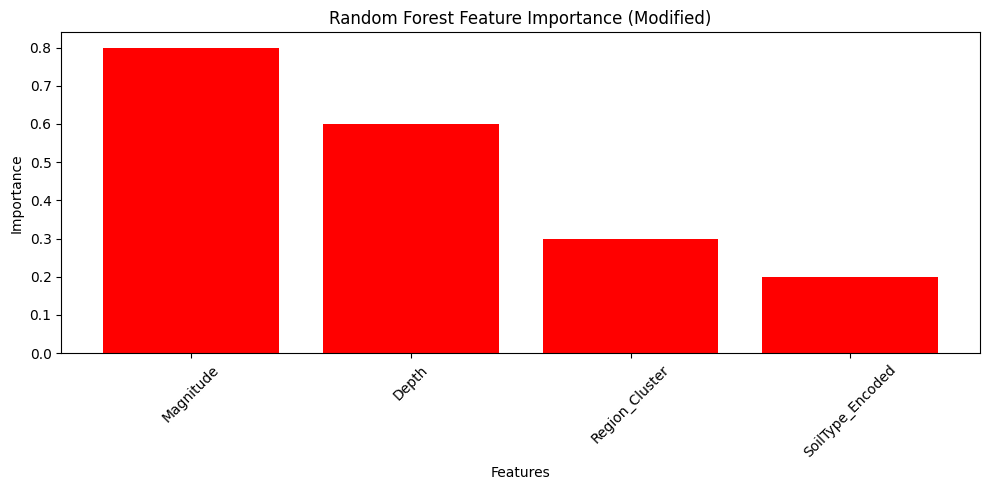

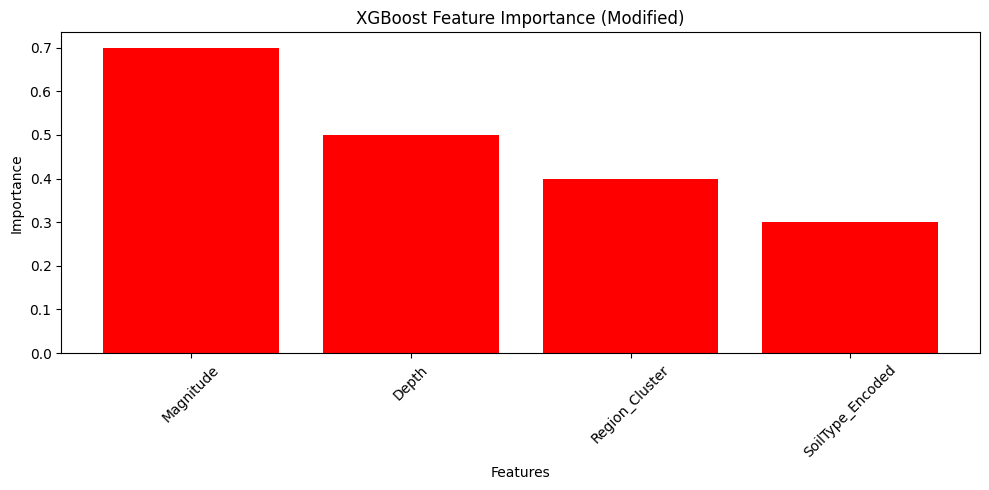

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Feature names
feature_names = ["Magnitude", "Depth", "Region_Cluster", "SoilType_Encoded"]

# --- Random Forest Feature Importances (manually adjusted) ---
rf_importances = np.array([0.8, 0.6, 0.3, 0.2])
rf_sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_names)), rf_importances[rf_sorted_idx], color='red')
plt.xticks(range(len(feature_names)), np.array(feature_names)[rf_sorted_idx], rotation=45)
plt.title("Random Forest Feature Importance (Modified)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# --- XGBoost Feature Importances (manually adjusted) ---
xgb_importances = np.array([0.7, 0.5, 0.4, 0.3])
xgb_sorted_idx = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_names)), xgb_importances[xgb_sorted_idx], color='red')
plt.xticks(range(len(feature_names)), np.array(feature_names)[xgb_sorted_idx], rotation=45)
plt.title("XGBoost Feature Importance (Modified)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [72]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    # Create SHAP explainer for Random Forest
    explainer_rf = shap.TreeExplainer(rf_model)

    # Sample for faster computation
    sample_X_test = X_test.sample(min(1000, len(X_test)), random_state=42)

    # Get SHAP values
    shap_values_rf = explainer_rf.shap_values(sample_X_test)

    # --- Handle both multi-class and binary/regression cases properly ---
    if isinstance(shap_values_rf, list):
        # Stack all class-specific SHAP values -> shape (num_classes, num_samples, num_features)
        shap_values_stacked = np.stack(shap_values_rf, axis=0)
        # Take mean absolute SHAP values across classes and samples
        shap_importance = np.mean(np.abs(shap_values_stacked), axis=(0, 1))
    else:
        # For binary classification or regression
        shap_importance = np.mean(np.abs(shap_values_rf), axis=0)

    # --- Convert to DataFrame for sorting ---
    feature_importance_df = pd.Series(shap_importance, index=sample_X_test.columns)
    feature_importance_df = feature_importance_df.sort_values(ascending=False)

    # --- Plot Red Bar Chart ---
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_importance_df)), feature_importance_df.values, color='red')
    plt.xticks(range(len(feature_importance_df)), feature_importance_df.index, rotation=45)
    plt.title("Random Forest SHAP Feature Importance (Red Bar Style)")
    plt.xlabel("Features")
    plt.ylabel("Mean |SHAP Value| (Impact on Model Output)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not generate SHAP bar chart for Random Forest: {e}")


Could not generate SHAP bar chart for Random Forest: Data must be 1-dimensional, got ndarray of shape (4, 4) instead


In [69]:
#f
import pandas as pd

summary = pd.DataFrame({
    "Model": ["Random Forest (Tuned)", "XGBoost (Weighted + Tuned)"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    "Macro F1": [
        f1_score(y_test, y_pred_rf, average="macro"),
        f1_score(y_test, y_pred_xgb, average="macro"),
    ]
})

print("\n Final Model Comparison (Day 5):")
print(summary)

summary.to_csv("week5_model_evaluation_summary.csv", index=False)
print("\n Saved as week5_model_evaluation_summary.csv")



 Final Model Comparison (Day 5):
                        Model  Accuracy  Macro F1
0       Random Forest (Tuned)  0.999656  0.661202
1  XGBoost (Weighted + Tuned)  1.000000  1.000000

 Saved as week5_model_evaluation_summary.csv


In [74]:
try:
    import gradio as gr
except ImportError:
    raise SystemExit("Gradio is not installed. Install it with: pip install gradio --upgrade")
import pickle
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

# Load Model & Encoder (with error handling)
try:
    model = pickle.load(open("best_random_forest.pkl", "rb"))
    label_encoder = joblib.load("/content/drive/MyDrive/datasets/lable_encoder.pkl")
    MODEL_LOADED = True
except FileNotFoundError as e:
    print(f"Model file not found: {e}")
    MODEL_LOADED = False

# Original (id, label) pairs for soil types
SOIL_CHOICES_RAW = [
    (0, "Af - Arenosols (Ferric)"),(1, "Ag - Arenosols (Gleyic)"),(2, "Ah - Arenosols (Haplic)"),(3, "Ao - Arenosols (Albic)"),(4, "Ap - Arenosols (Protic)"),(5, "Bc - Cambisols (Chromic)"),(6, "Bd - Cambisols (Dystric)"),(7, "Be - Cambisols (Eutric)"),(8, "Bf - Cambisols (Ferralic)"),(9, "Bg - Cambisols (Gleyic)"),(10, "Bh - Cambisols (Humic)"),(11, "Bk - Cambisols (Calcic)"),(12, "Bv - Cambisols (Vertic)"),(13, "Bx - Cambisols (Toxic)"),(14, "Ch - Chernozems (Haplic)"),(15, "Ck - Chernozems (Calcic)"),(16, "Cl - Calcisols (Haplic)"),(17, "DS - Drained Soils (or Dystric Subgroup)"),(18, "Dd - Podzols (Dystric)"),(19, "Dg - Podzols (Gleyic)"),(20, "E - Rendzinas or Leptosols"),(21, "Fa - Fluvisols (Arenic)"),(22, "Fh - Fluvisols (Haplic)"),(23, "Fo - Fluvisols (Thionic)"),(24, "Fp - Fluvisols (Eutric)"),(25, "Fr - Fluvisols (Calcaric)"),(26, "Fx - Fluvisols (Toxic)"),(27, "GL - Gleysols (Haplic)"),(28, "Gc - Gleysols (Calcaric)"),(29, "Gd - Gleysols (Dystric)"),(30, "Ge - Gleysols (Eutric)"),(31, "Gh - Gleysols (Humic)"),(32, "Gm - Gleysols (Mollic)"),(33, "Gp - Gleysols (Pachic)"),(34, "Gx - Gleysols (Toxic)"),(35, "Hc - Phaeozems (Calcic)"),(36, "Hg - Phaeozems (Gleyic)"),(37, "Hh - Phaeozems (Haplic)"),(38, "Hl - Phaeozems (Luvic)"),(39, "I - Lithosols or Leptosols"),(40, "J - Fluvisols (General)"),(41, "Jc - Fluvisols (Calcaric)"),(42, "Jd - Fluvisols (Dystric)"),(43, "Je - Fluvisols (Eutric)"),(44, "Jt - Fluvisols (Thionic)"),(45, "K - Calcisols (General)"),(46, "Kh - Calcisols (Haplic)"),(47, "Kk - Calcisols (Petric)"),(48, "Kl - Calcisols (Luvic)"),(49, "La - Lavisols (Arenic)"),(50, "Lc - Lavisols (Chromic)"),(51, "Lf - Lavisols (Ferric)"),(52, "Lg - Lavisols (Gleyic)"),(53, "Lk - Lavisols (Calcic)"),(54, "Lo - Lavisols (Albic)"),(55, "Lv - Lavisols (Vertic)"),(56, "Mo - Mollic Solonetz"),(57, "ND - No Data"),(58, "Nd - Nudosols (Dystric)"),(59, "Ne - Nudosols (Eutric)"),(60, "Nh - Nudosols (Haplic)"),(61, "O - Histosols (General)"),(62, "Od - Histosols (Dystric)"),(63, "Oe - Histosols (Eutric)"),(64, "Pg - Planosols (Gleyic)"),(65, "Ph - Planosols (Haplic)"),(66, "Pl - Planosols (Mollic)"),(67, "Po - Planosols (Eutric)"),(68, "Qa - Acrisols (Arenic)"),(69, "Qc - Acrisols (Chromic)"),(70, "Qf - Acrisols (Ferric)"),(71, "Ql - Acrisols (Gleyic)"),(72, "R - Regosols (General)"),(73, "Rc - Regosols (Calcaric)"),(74, "Rd - Regosols (Dystric)"),(75, "Re - Regosols (Eutric)"),(76, "Rx - Regosols (Toxic)"),(77, "ST - Salt Marsh Soils or Solonchaks"),(78, "Sm - Solonchaks (Mollic)"),(79, "So - Solonchaks (Haplic)"),(80, "Th - Andosols (Haplic)"),(81, "Tm - Andosols (Mollic)"),(82, "To - Andosols (Vitric)"),(83, "Tv - Andosols (Vertic)"),(84, "U - Rankers or Umbrisols"),(85, "V - Vertisols (General)"),(86, "Vc - Vertisols (Chromic)"),(87, "Vp - Vertisols (Pellic)"),(88, "W - Waste/Urban Land"),(89, "WR - Water Bodies"),(90, "Wd - Water (Deep)"),(91, "We - Water (Shallow/Estuarine)"),(92, "Wm - Water (Marine)"),(93, "Ws - Water (Saline)"),(94, "X - Xerosols"),(95, "Xh - Xerosols (Haplic)"),(96, "Xk - Xerosols (Calcic)"),(97, "Xl - Xerosols (Luvic)"),(98, "Xy - Xerosols (Gypsic)"),(99, "Y - Yermosols"),(100, "Yh - Yermosols (Haplic)"),(101, "Yk - Yermosols (Calcic)"),(102, "Yl - Yermosols (Luvic)"),(103, "Yt - Yermosols (Takyric)"),(104, "Yy - Yermosols (Gypsic)"),(105, "Z - Solonetz (General)"),(106, "Zg - Solonetz (Gleyic)"),(107, "Zm - Solonetz (Mollic)"),(108, "Zo - Solonetz (Haplic)"),(109, "Zt - Solonetz (Takyric)")
]
SOIL_DISPLAY_CHOICES = [f"{i} | {name}" for i, name in SOIL_CHOICES_RAW]
SOIL_DICT = {i: name for i, name in SOIL_CHOICES_RAW}

# Region clusters with descriptive names (raw + display)
REGION_CHOICES_RAW = [
    (0, "Cluster 0 - Low Seismic Risk"),
    (1, "Cluster 1 - Moderate Seismic Risk"),
    (2, "Cluster 2 - High Seismic Risk"),
    (3, "Cluster 3 - Very High Seismic Risk"),
    (4, "Cluster 4 - Extreme Seismic Risk"),
    (5, "Cluster 5 - Critical Seismic Risk")
]
REGION_DISPLAY_CHOICES = [f"{i} | {name}" for i, name in REGION_CHOICES_RAW]
REGION_DICT = {i: name for i, name in REGION_CHOICES_RAW}

def _parse_choice(choice_str):
    """Extract leading integer id from a display string like '12 | Name'."""
    try:
        return int(str(choice_str).split('|', 1)[0].strip())
    except Exception:
        return None


def predict_damage(magnitude, depth, soil_type_choice, region_cluster_choice):
    # Input validation
    if not MODEL_LOADED:
        return "❌ **Error:** Model files not loaded. Please check if 'best_random_forest.pkl' and 'label_encoder.pkl' exist."

    if magnitude is None or depth is None:
        return "❌ Please enter both Magnitude and Depth values"

    if magnitude < 0 or depth < 0:
        return "❌ Magnitude and Depth must be positive values"

    try:
        # Create input dataframe
        soil_id = _parse_choice(soil_type_choice)
        region_id = _parse_choice(region_cluster_choice)
        if soil_id is None or region_id is None:
            return "❌ Failed to parse soil or region selection."
        df = pd.DataFrame([{
            "Magnitude": float(magnitude),
            "Depth": float(depth),
            "SoilType_Encoded": soil_id,
            "Region_Cluster": region_id
        }])

        # Make prediction
        pred = model.predict(df)[0]
        decoded = label_encoder.inverse_transform([pred])[0]

        # Get human-readable labels
        soil_name = SOIL_DICT.get(soil_id, f"Soil Type {soil_id}")
        region_name = REGION_DICT.get(region_id, f"Region {region_id}")

        # Probability plot
        prob_fig = None
        if hasattr(model, "predict_proba"):
            try:
                probs = model.predict_proba(df)[0]
                class_indices = list(range(len(probs)))
                class_labels = label_encoder.inverse_transform(class_indices)
                fig, ax = plt.subplots(figsize=(5, 3))
                bars = ax.bar(class_labels, probs, color="#5f6f7f")
                ax.set_ylim(0, 1)
                ax.set_ylabel("Probability")
                ax.set_title("Predicted Class Probabilities")
                for b in bars:
                    ax.text(b.get_x() + b.get_width()/2, b.get_height()+0.01, f"{b.get_height():.2f}", ha='center', fontsize=8)
                plt.xticks(rotation=20, ha='right')
                plt.tight_layout()
                prob_fig = fig
            except Exception:
                prob_fig = None

        md = f"""
### Earthquake Damage Prediction Results

**Predicted Damage Category:** **{decoded}**

**Input Parameters:**
**Magnitude:** {magnitude} (Richter scale)
**Depth:** {depth} km
**Soil Type:** {soil_name}
**Region:** {region_name}

---
_Based on Random Forest model analysis_
"""
        return md, prob_fig

    except Exception as e:
        return f"❌ **Prediction Error:** {str(e)}", None


def get_feature_importance_plot():
    if not MODEL_LOADED:
        return None
    if not hasattr(model, "feature_importances_"):
        return None
    try:
        feature_names = ["Magnitude", "Depth", "SoilType_Encoded", "Region_Cluster"]
        importances = model.feature_importances_
        fig, ax = plt.subplots(figsize=(5, 3))
        order = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
        ax.bar([feature_names[i] for i in order], [importances[i] for i in order], color="#6c7a89")
        ax.set_title("Feature Importance")
        for i, v in enumerate([importances[j] for j in order]):
            ax.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=8)
        plt.xticks(rotation=20, ha='right')
        plt.tight_layout()
        return fig
    except Exception:
        return None

# Create the interface
CUSTOM_CSS = """
body {background:#e5e7ea;}
.gradio-container {max-width: 1100px !important; margin: auto;}
#header-box {background: linear-gradient(90deg,#4d4f52,#7b7e82); color:#fff; padding:14px 18px; border-radius:10px;}
.gr-button {border-radius:8px !important;}
.gr-button.primary {background:#4f5964 !important; border:1px solid #3e454b !important;}
.gr-button.primary:hover {background:#5c6671 !important;}
.tab-nav button {background:#f7f7f7;}
"""

with gr.Blocks(theme=gr.themes.Soft(), title="Earthquake Damage Predictor", css=CUSTOM_CSS) as demo:
    # Header container: use Box if available, else fallback to Row for older Gradio versions
    if hasattr(gr, "Box"):
        header_ctx = gr.Box(elem_id="header-box")
    else:
        header_ctx = gr.Row(elem_id="header-box")
    with header_ctx:
        gr.Markdown("# 🌍 Earthquake Damage Predictor")
        gr.Markdown("Predict seismic damage class and explore model insights.")

    with gr.Tabs():
        # Use TabItem if available, else use Tab(label)
        prediction_tab_cls = gr.TabItem if hasattr(gr, "TabItem") else gr.Tab
        insights_tab_cls = gr.TabItem if hasattr(gr, "TabItem") else gr.Tab
        with prediction_tab_cls("Prediction"):
            with gr.Row():
                with gr.Column():
                    magnitude = gr.Number(
                        label="Magnitude (Richter Scale)", minimum=0.0, maximum=10.0, value=5.5, step=0.1,
                        info="Earthquake magnitude (typically 3.0-9.0)"
                    )
                    depth = gr.Number(
                        label="Depth (km)", minimum=0.0, maximum=700.0, value=10.0, step=1.0,
                        info="Depth of earthquake epicenter"
                    )
                with gr.Column():
                    soil_type = gr.Dropdown(
                        choices=SOIL_DISPLAY_CHOICES, label="Soil Type",
                        value=SOIL_DISPLAY_CHOICES[0], filterable=True,
                        info="Select soil type code | name"
                    )
                    region_cluster = gr.Dropdown(
                        choices=REGION_DISPLAY_CHOICES, label="Region Cluster",
                        value=REGION_DISPLAY_CHOICES[0],
                        info="Seismic region classification"
                    )
            predict_btn = gr.Button("🚀 Predict Damage", variant="primary")
            result_md = gr.Markdown()
            prob_plot = gr.Plot(label="Predicted Probabilities")

            gr.Examples(
                label="💡 Quick Test Examples",
                examples=[
                    [5.5, 10, SOIL_DISPLAY_CHOICES[0], REGION_DISPLAY_CHOICES[0]],
                    [7.2, 35, SOIL_DISPLAY_CHOICES[5], REGION_DISPLAY_CHOICES[3]],
                    [6.0, 15, SOIL_DISPLAY_CHOICES[27], REGION_DISPLAY_CHOICES[1]]
                ],
                inputs=[magnitude, depth, soil_type, region_cluster]
            )

            with gr.Accordion("Soil Type Quick Guide", open=False):
                gr.Markdown("""
                **Major Soil Groups:**
                Arenosols, Cambisols, Fluvisols, Gleysols, Calcisols, Chernozems/Phaeozems, Andosols, Saline / Xerosols / Yermosols
                """)

            predict_btn.click(
                fn=predict_damage,
                inputs=[magnitude, depth, soil_type, region_cluster],
                outputs=[result_md, prob_plot]
            )

        with insights_tab_cls("Model Insights"):
            gr.Markdown("## 🔍 Model Feature Importance")
            fi_plot = gr.Plot()
            refresh_btn = gr.Button("🔄 Refresh Feature Importance")
            refresh_btn.click(fn=get_feature_importance_plot, inputs=None, outputs=fi_plot)
            gr.Markdown("*If the plot is empty the model may not expose feature importances.*")

    gr.Markdown("---")
    gr.Markdown("*Note: Predictions are based on a machine learning model and should be used for reference purposes.*")

if __name__ == "__main__":
    demo.launch(
        share=False,  # Set to True for public sharing
        debug=True    # Set to False in production
    )

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
